# Introduction

With the recent publication of bat speed into Baseball Savant's database, MLB teams have been provided another metric to leverage in player evaluation & analysis (if they haven't been tracking this metric already, that is). The new metric opens up yet another avenue to explore, providing us insight into how **bat speed may influence a player's success at the plate**. Several different questions can be brought up, including: what bat speed is considered 'above-average'? Does a higher bat speed actually implicate better performance? Are there certain bat speeds which perform better against certain pitches? If bat speed declines as a player grows in age, at what rate does bat speed drop by? 

In the following analysis, I will answer all of the questions above while also exploring the player evaluation & development implications of this metric. Specifically, I hope to accomplish the following:
1. Explore & establish the **assosciation between bat speed and batting peformance**
2. Create **hitting classifications** based on an individual player's bat speed, identifying them by their perceived batting approach
3. Analyze these new classifications and discuss their **implications on team performance and roster construction**
4. Create a **predictive model** which helps us **identify players who could significantly improve with modifications to their bat speed**, simulatanoeusly identifying other players who are likely to regress from expected decreases in bat speed. 

By answering such questions, I hope to provide another insight for MLB teams & research analysts to add in their player evaluation proccesses.

**NOTE:** Due to the limits of Kaggle, I wasn't able to put down all of my thoughts & data visualizations within this notebook. Please use this notebook to view my Python code & to see how my preditce models / data visualizations were created. For my complete analysis & thoughts, please see my presentation: https://www.canva.com/design/DAGOT5eoigA/cOZjWLsLBVtNujAeWy5goA/edit?utm_content=DAGOT5eoigA&utm_campaign=designshare&utm_medium=link2&utm_source=sharebutton


**DATA SOURCES:** Baseball Savant, FanGraphs

**PHOTO CREDITS:** MLB.com


In [632]:
# Install Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
from matplotlib import colormaps
from scipy import stats


# Ignore warnings for all of the future plots
import warnings
warnings.filterwarnings('ignore')

To conduct my analysis, I'll start by using the 'Stats as of Aug 16th.csv' dataset. The dataset consists of a player's hitting metrics thus far (as of August 16th), including their average bat speed, wOBA, HardHit%, and other hitting metrics (extracted using Baseball Savant's 'custom leaderboard' function). I set a minimum at 250 PA, being close to the cut-off for being 'qualified' at this point on the season (the cut-off point is approximately 380 PAs at 122 games played. Thus, 250 PAs would allow us to analyze players who've established themselves in the league, but may not have been 'qualified' just yet). As such, the dataset includes **265 different hitters**.

In [633]:
# Load in grouped dataset
grouped = pd.read_csv('/kaggle/input/grouped-stats/Stats as of Aug 16th.csv')
grouped.head()

,"last_name, first_name",player_id,year,pa,home_run,k_percent,bb_percent,xba,xslg,xwoba,...,avg_best_speed,avg_hyper_speed,whiff_percent,swing_percent,pull_percent,straightaway_percent,opposite_percent,groundballs_percent,flyballs_percent,linedrives_percent
0,"Blackmon, Charlie",453568,2024,372,8,16.9,8.3,0.246,0.361,0.301,...,95.528256,91.861783,18.7,48.6,44.0,35.2,20.9,38.8,25.3,23.8
1,"McCutchen, Andrew",457705,2024,437,16,26.1,11.7,0.237,0.443,0.340,...,99.744797,94.015093,29.1,41.8,38.1,41.9,20.0,41.9,27.2,21.9
2,"Turner, Justin",457759,2024,395,7,18.5,10.6,0.248,0.373,0.324,...,96.514351,92.314967,17.1,45.2,40.4,34.8,24.8,34.8,29.3,28.5
3,"Santana, Carlos",467793,2024,446,17,17.3,10.3,0.245,0.419,0.327,...,99.299451,93.901409,23.5,42.9,48.9,32.8,18.3,37.9,29.3,22.7
4,"Pham, Tommy",502054,2024,350,7,20.6,8.6,0.282,0.433,0.341,...,100.606692,94.632794,22.0,40.7,35.4,37.0,27.6,43.1,20.7,30.5


In [634]:
grouped.info

<bound method DataFrame.info of     last_name, first_name  player_id  year   pa  home_run  k_percent  \
0       Blackmon, Charlie     453568  2024  372         8       16.9   
1       McCutchen, Andrew     457705  2024  437        16       26.1   
2          Turner, Justin     457759  2024  395         7       18.5   
3         Santana, Carlos     467793  2024  446        17       17.3   
4             Pham, Tommy     502054  2024  350         7       20.6   
..                    ...        ...   ...  ...       ...        ...   
260       Schanuel, Nolan     694384  2024  471        12       16.6   
261       Langford, Wyatt     694671  2024  401         7       20.7   
262          Young, Jacob     696285  2024  396         2       19.9   
263      Merrill, Jackson     701538  2024  450        17       18.2   
264     Yoshida, Masataka     807799  2024  295         8       13.6   

     bb_percent    xba   xslg  xwoba  ...  avg_best_speed  avg_hyper_speed  \
0           8.3  0.246  0

I'll also be working with the pitch-level data for this analysis (extracted using Baseball Savant's 'search' function). It contains all of 'competitive swings' on pitches recorded until Aug 16th, effectively containing every swing (that's not a bunt) from a player within this season. I'll also use this pitch level dataset to extract the assigned batting stance of the player (via the 'stand' variable). 

**Important Notes:** 
* **Swing data is only up to April 3rd**. This is when Statcast first began recording this new data
* Due to the limit on Statcast's search functionality, I could only download all of the data in intervals (e.g., games from March to April 8th, April 9th to April 22nd, etc.). As such, I'll need to merge all of these datasets to complete the data.
* Due to Statcast's functionality in their search option and 'customer leaderboards' feature, there was a discrepancy in the number of players provided when performing the search. Thus, I performed a search for all of the pitches recorded within the 2024 season (on attempted swings). As the 'custom leaderboards' option is more reliable in this case, I'll create a new dataframe which filters out any players which aren't listed in our original dataset (the min. 250 PA dataset, titled 'grouped' within the analysis). Effectively, I will have all of the pitch data for the names listed in our original dataset

In [635]:
# Load in all of the pitch data
apr3 = pd.read_csv('/kaggle/input/pitch-data-0816/April 3rd.csv')
apr9 = pd.read_csv('/kaggle/input/pitch-data-0816/April 9th.csv')
apr24 = pd.read_csv('/kaggle/input/pitch-data-0816/April 24th.csv')
may9 = pd.read_csv('/kaggle/input/pitch-data-0816/May 9th.csv')
may23 = pd.read_csv('/kaggle/input/pitch-data-0816/May 23rd.csv')
jun7 = pd.read_csv('/kaggle/input/pitch-data-0816/June 7th.csv')
jun21 = pd.read_csv('/kaggle/input/pitch-data-0816/June 21st.csv')
jul5 = pd.read_csv('/kaggle/input/pitch-data-0816/July 5th.csv')
jul19 = pd.read_csv('/kaggle/input/pitch-data-0816/July 19th.csv')
aug2 = pd.read_csv('/kaggle/input/pitch-data-0816/August 2nd.csv')

# Combine all of the data sets
df = pd.concat([apr3, apr9, apr24, may9, may23, jun7, jun21, jul5, jul19, aug2], ignore_index=True)
df.head()


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length
0,FF,2024-04-08,93.4,-2.77,5.78,"Bryant, Kris",592178,668678,field_out,hit_into_play,...,3,3,4,Standard,Standard,208.0,-0.066,-0.458,73.65551,7.48645
1,KC,2024-04-08,80.1,-3.02,5.70,"Bryant, Kris",592178,668678,NaN,foul,...,3,3,4,Standard,Standard,41.0,0.000,-0.168,72.57554,8.30704
2,CU,2024-04-08,82.3,-2.28,5.61,"Stewart, DJ",621466,450203,NaN,foul,...,4,4,4,Infield shade,Standard,59.0,0.000,0.000,66.75303,8.07263
3,CU,2024-04-08,82.8,-2.28,5.63,"Stewart, DJ",621466,450203,NaN,foul,...,4,4,4,Infield shade,Standard,61.0,0.000,0.000,67.04687,8.12449
4,CU,2024-04-08,82.5,-2.29,5.63,"Stewart, DJ",621466,450203,NaN,foul,...,4,4,4,Infield shade,Standard,59.0,0.000,0.000,79.45243,7.70645


As per my note, let's filter for just the players in my original dataset (titled 'grouped'). Effectively, we will have all the swings from players with that satisfy my min. 250 PA rule.

In [636]:
# Filter the 'pitch' dataset to include only rows with IDs present in the 'grouped' dataset
pitch = df[df['batter'].isin(grouped['player_id'])]

pitch.head()

# Check that the dataframe has 265 unique batter IDs
print(len(pitch['batter'].unique()))

265


In [637]:
pitch.info

<bound method DataFrame.info of        pitch_type   game_date  release_speed  release_pos_x  release_pos_z  \
6              KC  2024-04-08           79.9          -3.04           5.66   
7              FF  2024-04-08           91.9          -2.83           5.84   
8              SL  2024-04-08           84.5          -1.96           4.96   
10             FF  2024-04-08           94.1          -1.71           5.14   
11             FF  2024-04-08           91.5          -2.77           5.82   
...           ...         ...            ...            ...            ...   
211416         FF  2024-08-02           89.3          -1.78           6.08   
211417         FF  2024-08-02           92.9          -1.34           5.37   
211418         FF  2024-08-02           93.1          -2.54           6.28   
211419         FF  2024-08-02           95.9          -2.02           5.87   
211420         FF  2024-08-02           96.7           2.51           5.55   

             player_name  batte

# Dataset Exploration - Analyzing Bat Speed & Identifying Different Types of Batters (Creating Batter Classifications)

Before proceeding with our analysis, let's establish the baseline for our results. By answering some of these surface level questions, we can derive further insights as we investigate different aspects of the data

## *What is the average bat speed (mph) for hitters? Is there a discrepancy among left and right-handed batters?*

Let's begin by establishing our expectations regarding bat speed as a metric (i.e., what defines an 'above-average' bat speed?). We can do this by observing the mean bat speed and the distribution amongst players

In [638]:
# Calculate mean bat_speed
print(grouped['avg_swing_speed'].mean())

71.58830188679246


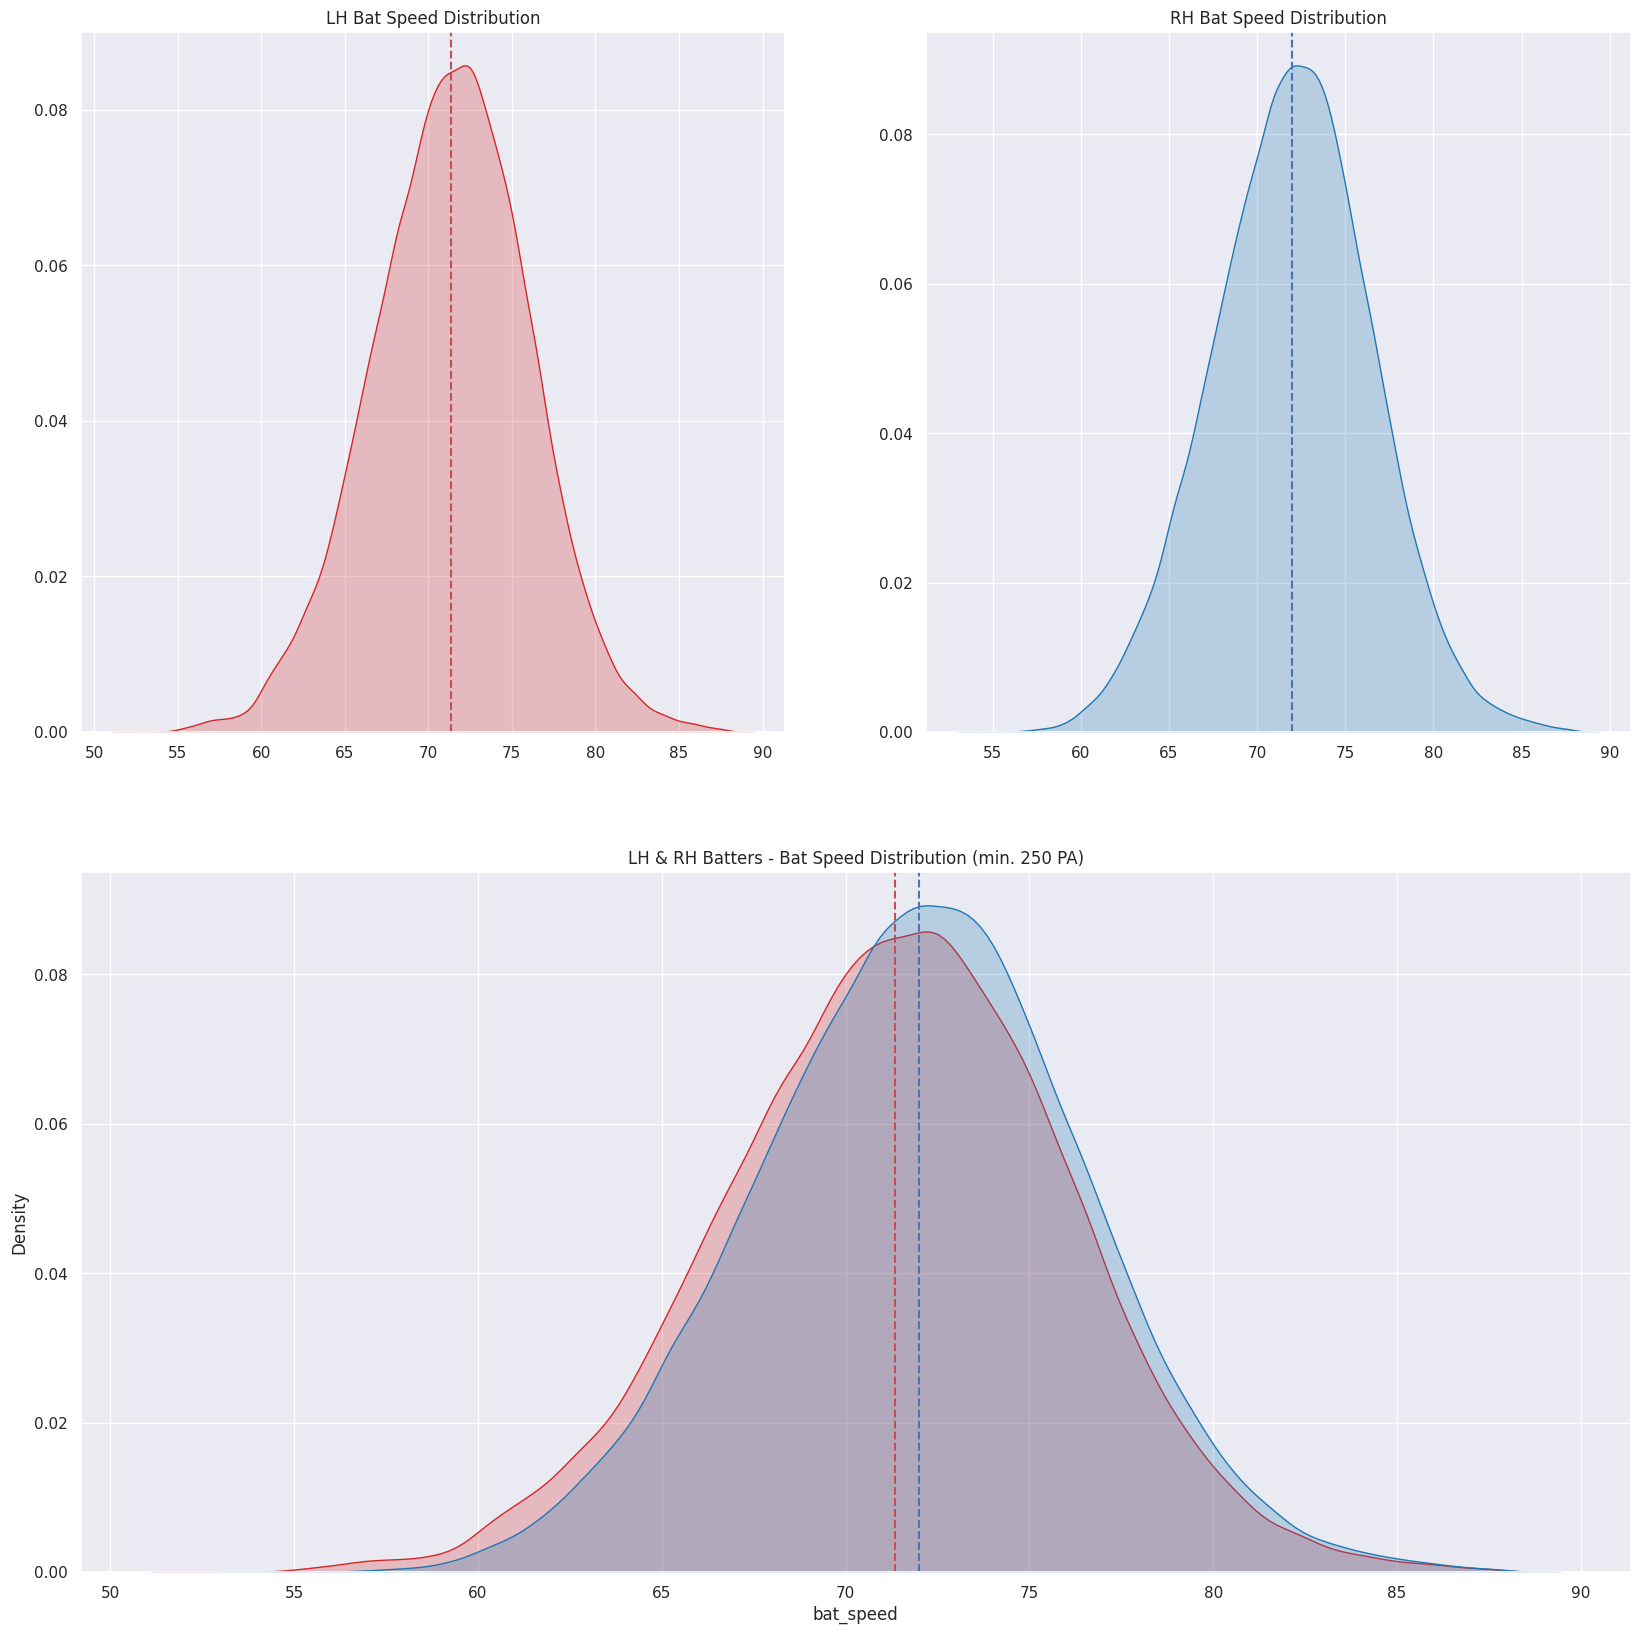

In [639]:
# Create Figure / Base for Subplots
fig, ax = plt.subplots(figsize = (20, 20))

# Add Axes and Individual Grids - Subplot Grids
ax1 = plt.subplot2grid(shape=(2,2), loc=(0,0))
ax2 = plt.subplot2grid(shape=(2,2), loc=(0,1))
ax3 = plt.subplot2grid(shape=(2,1), loc=(1,0))


# INDIVIDUAL GRIDS 

# 'Lefty' Bat Speed Distribution Distribution
Left = pitch[pitch['stand'] == "L"]
sns.set(rc={'figure.figsize':(10,5)})
ax1 = sns.kdeplot(Left['bat_speed'], fill = True, ax=ax1, color = 'tab:red')
ax1.set_title('LH Bat Speed Distribution')
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.axvline(x=np.mean(Left['bat_speed']), color='r', linestyle='--')
# 'Righty' Bat Speed Distribution Distribution
Right = pitch[pitch['stand'] == "R"]
ax2 = sns.kdeplot(Right['bat_speed'], fill = True, ax=ax2, color = 'tab:blue')
ax2.set_title('RH Bat Speed Distribution')
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.axvline(x=np.mean(Right['bat_speed']), color='b', linestyle='--')


# All hit classes in One Graph (ax5)
sns.kdeplot(Left['bat_speed'], fill = True, ax=ax3, color = 'tab:red')
sns.kdeplot(Right['bat_speed'], fill = True, ax=ax3, color = 'tab:blue')
ax3.set_title('LH & RH Batters - Bat Speed Distribution (min. 250 PA)')
ax3.axvline(x=np.mean(Left['bat_speed']), color='r', linestyle='--')
ax3.axvline(x=np.mean(Right['bat_speed']), color='b', linestyle='--')

**INSIGHTS & IMPLICATION ON ANALYSIS:**

**There is minimal difference in average bat speed and its distribution among right and left-handed batters (~0.05 mph difference).** Interestingly, right-handed batters slightly have the edge on left-handed batters in bat speed. This may be due to the higher bat speeds right-handed batters have at both the lower and higher ends of the distribution (e.g., ~60mph and ~85 mph), consistently being above left-handed batters. While this difference is quite minimal, is something we can keep in mind as we analyze RH/LH splits further into this analysis. 

From an overall standpoint, bat speeds will range from 60 - 85 mph. **Most players will set near the mid-low 70s (~72mph)**, which is in line with our calculated average (71.588 mph). It also aligns with the noted average when Statcast first published swing data, being around 72mph. Understanding this information, we'll want to analyze how deviations from this 72 mph will influence hitting performance.

## *How does bat speed influence a player's hitting performance? Do higher bat speeds always implicate better performance?*

Based on intuition, we always assume that higher bat speeds implicate better hitting performance (which is quite a reasonable assumption, one would expect a higher bat speed to consistently result in higher exit velocities & more favourable results). Now that we have this data available, let's confirm this assumption & attempt to quantify its strength with different hitting metrics.

The correlation between bat speed and hard hit percent is: 0.7678865956768574
The correlation between bat speed and xISO is: 0.6513287381145276
The correlation between bat speed and xBA is: 0.12595150839708044
The correlation between bat speed and xWOBA is: 0.47951772336195064
 


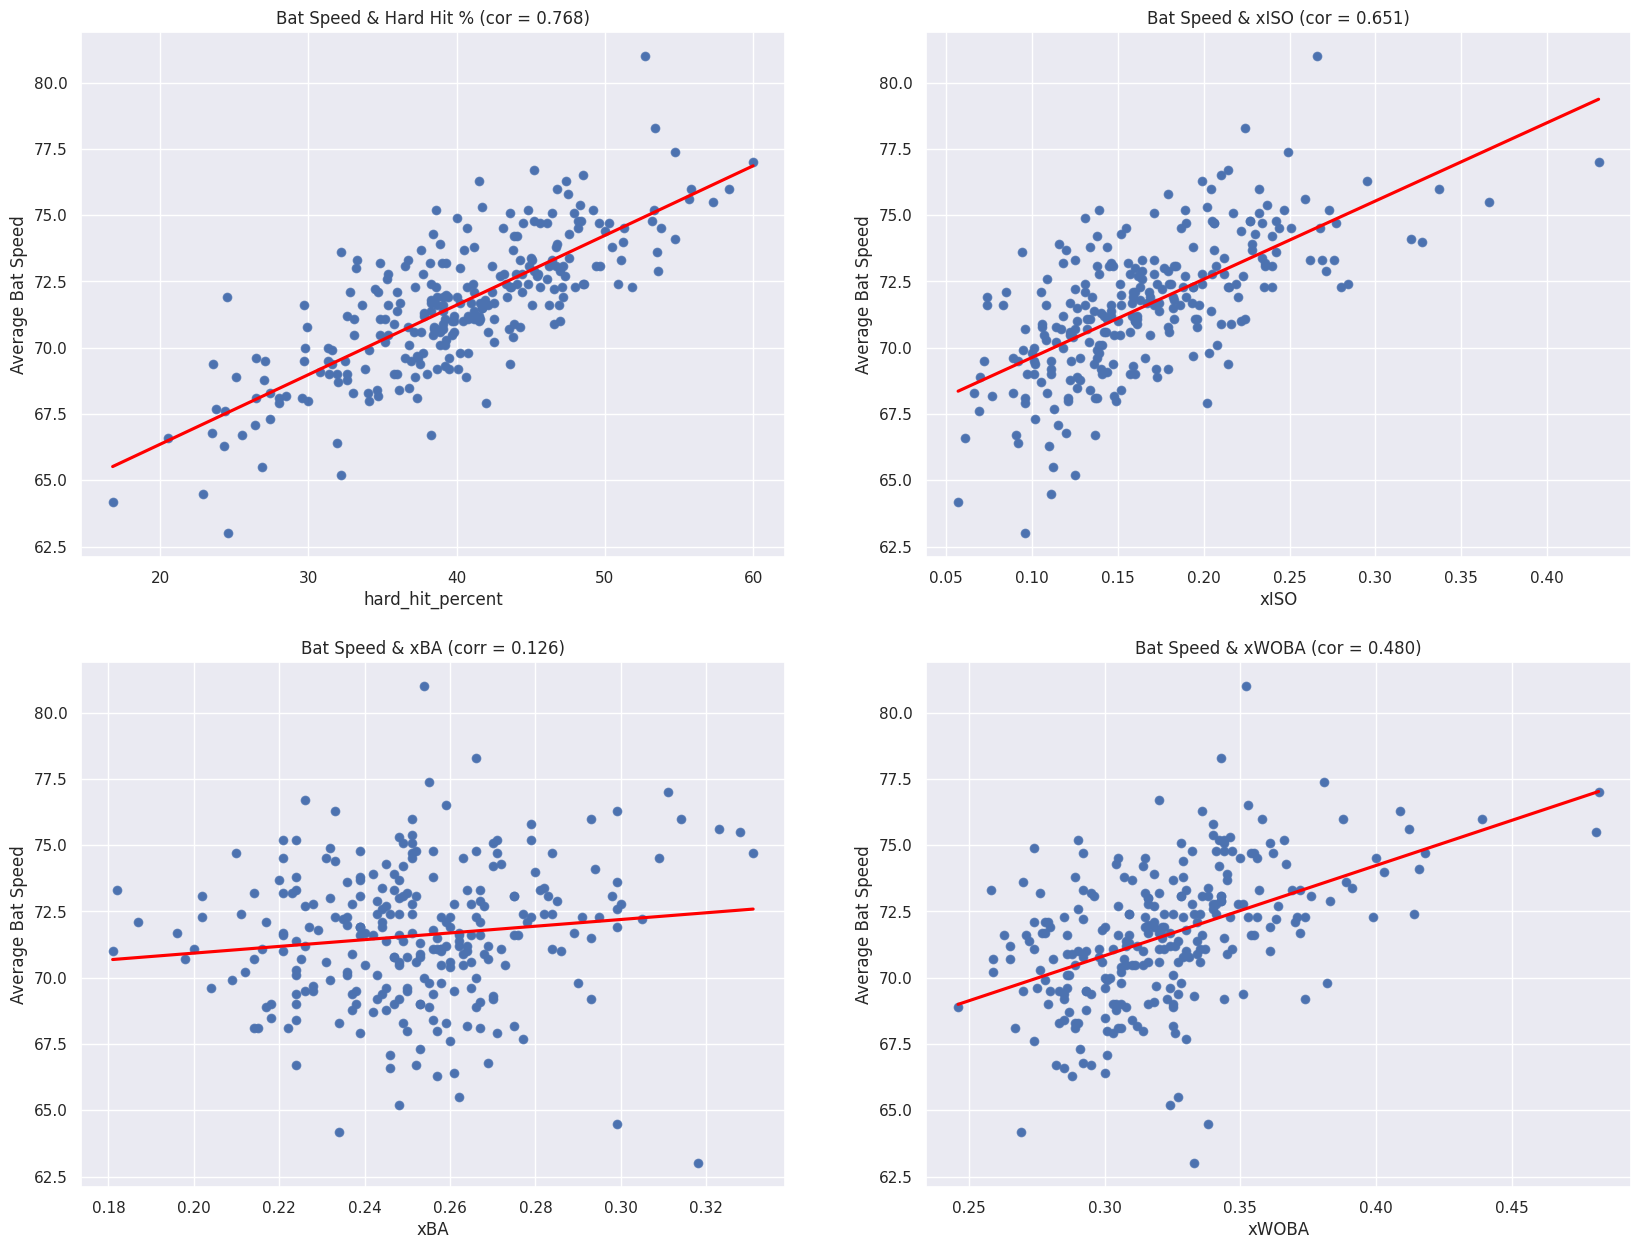

In [640]:
# Create the frame for subplots
fig, ax = plt.subplots(figsize = (30,30))

# Add Axes and Individual Grids - Subplot Grids
ax1 = plt.subplot2grid(shape=(2,2), loc=(0,0))
ax2 = plt.subplot2grid(shape=(2,2), loc=(0,1))
ax3 = plt.subplot2grid(shape=(2,2), loc=(1,0))
ax4 = plt.subplot2grid(shape=(2,2), loc=(1,1))


# Bat Speed by Hard Hit Percent Scatter Plot
sns.regplot(x = 'hard_hit_percent', y = 'avg_swing_speed', ci=False, line_kws={'color':'red'}, ax=ax1, data = grouped); # Trend Line
ax1 = grouped.plot(kind='scatter', x = 'hard_hit_percent', y = 'avg_swing_speed', ax=ax1, ylabel = 'Average Bat Speed', xlabel = 'hard_hit_percent', title = 'Bat Speed & Hard Hit % (cor = 0.768)', figsize = (20, 15))

# Bat Speed by xISO Scatter Plot
sns.regplot(x = 'xiso', y = 'avg_swing_speed', ci=False, line_kws={'color':'red'}, ax=ax2, data = grouped); # Trend Line
ax2 = grouped.plot(kind='scatter', x = 'xiso', y = 'avg_swing_speed', ax=ax2, ylabel = 'Average Bat Speed', xlabel = 'xISO', title = 'Bat Speed & xISO (cor = 0.651)', figsize = (20, 15))


# Bat Speed by xBA Scatter Plot
sns.regplot(x = 'xba', y = 'avg_swing_speed', ci=False, line_kws={'color':'red'}, ax=ax3, data = grouped); # Trend Line
ax3 = grouped.plot(kind='scatter', x = 'xba', y = 'avg_swing_speed', ax=ax3, ylabel = 'Average Bat Speed', xlabel = 'xBA', title = 'Bat Speed & xBA (corr = 0.126)', figsize = (20, 15))

# Bat Speed by xWOBA Scatter Plot
sns.regplot(x = 'xwoba', y = 'avg_swing_speed', ci=False, line_kws={'color':'red'}, ax=ax4, data = grouped); # Trend Line
ax4 = grouped.plot(kind='scatter', x = 'xwoba', y = 'avg_swing_speed', ax=ax4, ylabel = 'Average Bat Speed', xlabel = 'xWOBA', title = 'Bat Speed & xWOBA (cor = 0.480)', figsize = (20, 15))


# Print the correlation between bat speed & each hitting metric
correlation1 = grouped['avg_swing_speed'].corr(grouped['hard_hit_percent'])
print(f"The correlation between bat speed and hard hit percent is: {correlation1}")
correlation2 = grouped['avg_swing_speed'].corr(grouped['xiso'])
print(f"The correlation between bat speed and xISO is: {correlation2}")
correlation3 = grouped['avg_swing_speed'].corr(grouped['xba'])
print(f"The correlation between bat speed and xBA is: {correlation3}")
correlation4 = grouped['avg_swing_speed'].corr(grouped['xwoba'])
print(f"The correlation between bat speed and xWOBA is: {correlation4}")

print(' ') # Add line for spacing

**INSIGHTS & IMPLICATIONS ON ANALYSIS**
* As one would expect, **higher bat speeds have a strong and positive, linear assosciation with hard hit percentage (0.768)**. Given the strength of this relationship, its fair to conclude that a higher bat speed implicates a higher launch speed (on average)
* While not as strong as launch speed, there is a **somewhat strong and positive, linear assosciation between bat speed and xISO (0.651)**. Recognizing this, its fair to conclude that (on average) players with higher bat speeds will hit for more power, thus resulting in higher xISO values.
* Our main deviation is with the **xBA metric which bat speed has a weaker assosciation to** (evidenced by the lack of concentration around the trend line and its less steep slope). This may be due to the varying batting approaches which hitters take, with some choosing to slow down their bat in an attempt to hit for higher averages (thus having a higher xBA despite a low avg. bat speed). In the next section, I will further analyze this idea and attempt to create classiifications for these different batting approaches.
* There is a **moderately strong, positive linear assosciation between bat speed & xWOBA (0.480)**. As xwOBA is a bit of a combination between xBA and power output metrics, it makes sense for this correlation to fall in between all of our other metrics. 

 ## *What are the types of players at each level of bat speed? Using their xBA, can we categorize any of these players?*
 
Now that we've explored the relationship between bat speed and different hitting metrics, let's attempt to classify each hitter. Specifically, what types of hitters do we notice at varying levels of bat speed and how does their performance vary? To create these classificaitons, I'll rely on the xBA and bat speed plot. 

I chose to focus on the xBA and bat speed plot as xBA serves as a perfect indicator for a player's intention at the plate. It factors in the player's ability to hit to get on base, while also considering the bat speeds which they generate. Thus, it serves as a perfect metric to distinguish players who hit for higher batting averages vs. those who solely hit for power, especially when its plotted against bat speed data. 

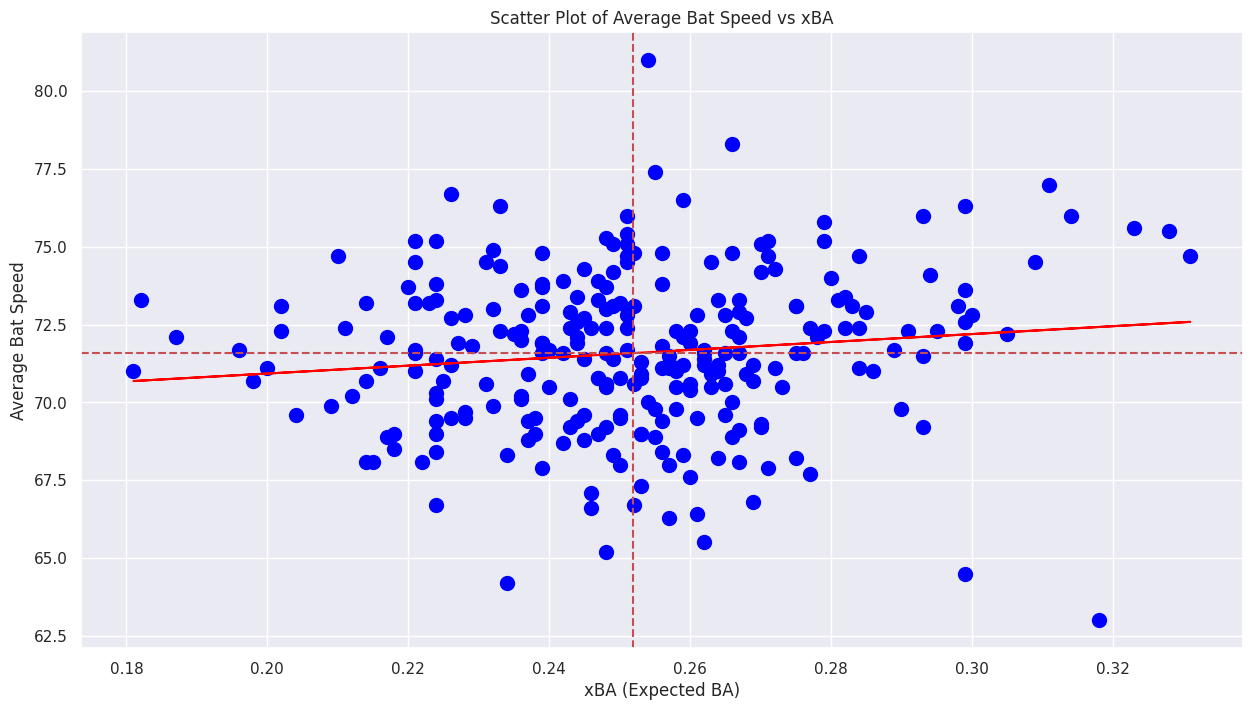

In [641]:
# Create the scatter plot
plt.figure(figsize=(15, 8))
plt.scatter(grouped['xba'], grouped['avg_swing_speed'], color='blue', s=100)
plt.xlabel('xBA (Expected BA)')
plt.ylabel('Average Bat Speed')
plt.title('Scatter Plot of Average Bat Speed vs xBA')
plt.grid(True)


# Plot a trend line
# Calculate the trend line (linear regression)
coefficients = np.polyfit(grouped['xba'], grouped['avg_swing_speed'], 1)  # Fit a 1st degree polynomial (linear)
polynomial = np.poly1d(coefficients)
trendline = polynomial(grouped['xba'])
# Plot the trend line
plt.plot(grouped['xba'], trendline, color='red', label='Trend line')

# Plot averages
plt.axhline(y=np.mean(grouped['avg_swing_speed']), color='r', linestyle='--')
plt.axvline(x=np.mean(grouped['xba']), color='r', linestyle='--')


plt.show()

Moving forward in our analysis, I'll need to identify different **segments / classifications** to further analyze the importance of bat speed. I will group players based on their respective bat speed and xBA, further analyzing how their approach has impacted other stats beyond xBA. I also hope to analyze how these groups are distributed among MLB rosters. *Do more successful offensive teams have more of a certain group? Or is a balance of the groups more effective?* Beyond roster-building implications, it may provide more perspective from a player development perspective. *Are certain players taking the wrong hitting approach in certain match ups? Are they a candidate to switch to another 'hitting type'?* In these cases, I'll leverage pitch-level data (I will explain how I will integrate this data when the time comes).

To identify different segments, I'll leverage the dotted average lines on the plot above. Specifically, we can note 4 quadrants of players, all of which have a seemingly different batting approaches yielding different results:

**THE 4 CLASSIFICATIONS:**
1. **Elite Batters (Upper Right Quadrant)**. These are the players which swung an above average bat speed and hit an above average xBA. Given the favourable metrics, this group can be looked to as the 'ideal' candidates for player acquisition (at face value). The higher bat speeds not only implicated their ability to hit for higher averages, but it may also implicate an ability to generate better run values or greater on-base opportunities (think Shohei Ohtani, Aaron Judge)
2. **Power-Oriented Batters (Upper Left Quadrant)** These are players who swung an above average bat speed, but fell below the average xBA. Most of these players will likely be pure-power hitters who are solely focused on XBH (think Jorge Soler, Giancarlo Stanton), or are players who simply struggle at the MLB level despite an above-average bat speed.
3. **.BA Oriented Batters (Lower Right Quadrant)**. These are the players who swung at below average bat speeds, but hit above the average xBA. Players within this group are likely to be our batting average-oriented hitters, focused on getting on base to set-up other hitters (think Luis Arraez, Steven Kwan)
4. **Struggling Batters (Lower Left Quadrant)**. These are the players who swung below average bat speeds, and hit below the average xBA. Players within this category likely aren't known for their hitting, lacking in both power and their ability to get on base. In most cases, these individuals will be more fielding-oriented players or hitters are struggling in 2024 (think Dominic Smith, Whit Merrifield, Kevin Kiermaier)

In [642]:
# Fucntion to create & Assign batter classes
def assign_batter_class(row):
    bat_speed = row['avg_swing_speed']
    xba = row['xba']
    
    # Mean bat_speed = 71.58830188679246 Mean xBA = 0.25192075471698117
    
    if bat_speed > 71.58830188679246 and xba > 0.25192075471698117:
        hit_class = "Elite"
    elif bat_speed > 71.58830188679246 and xba < 0.25192075471698117:
        hit_class = "Power Oriented"
    elif bat_speed < 71.58830188679246 and xba > 0.25192075471698117:
        hit_class = ".BA Oriented"
    elif bat_speed < 71.58830188679246 and xba < 0.25192075471698117:
        hit_class = "Struggling"
    else:
        "NA"
    return hit_class

# Apply function
grouped['hit_class'] = grouped.apply(assign_batter_class, axis = 1)


# Apply same classifications to pitch-level data
pitch = pitch.merge(grouped[['player_id', 'hit_class']], left_on='batter', right_on='player_id', how='left')

Let's apply these new classifications and see what they look like:

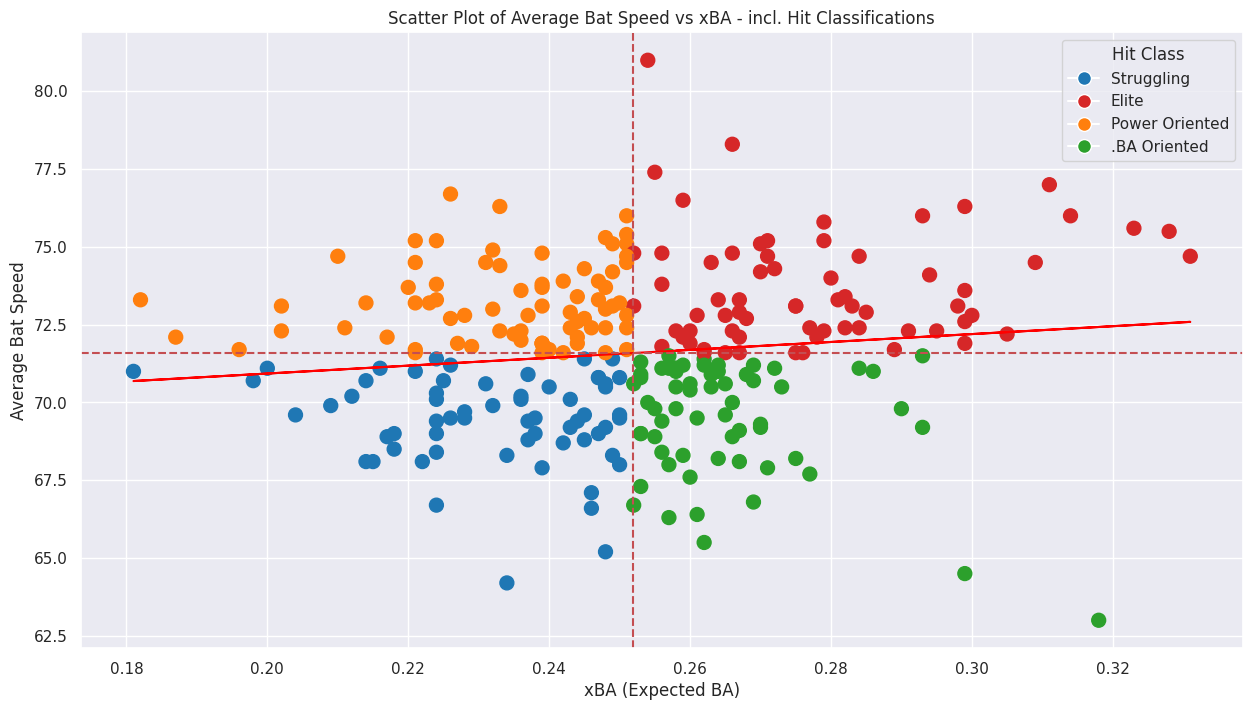

In [643]:
# New Scatter Plot with appropiate classification

# Define a color map for the 'hit_class' categories
color_map = {'Struggling':'tab:blue', 'Elite':'tab:red', 'Power Oriented':'tab:orange', '.BA Oriented':'tab:green'}
# Map the 'hit_class' values to colors
colors = grouped['hit_class'].map(color_map)

# Create the scatter plot
plt.figure(figsize=(15, 8))
plt.scatter(grouped['xba'], grouped['avg_swing_speed'], color=colors, s=100)
plt.xlabel('xBA (Expected BA)')
plt.ylabel('Average Bat Speed')
plt.title('Scatter Plot of Average Bat Speed vs xBA - incl. Hit Classifications')
plt.grid(True)

# Plot a trend line
# Calculate the trend line (linear regression)
coefficients = np.polyfit(grouped['xba'], grouped['avg_swing_speed'], 1)  # Fit a 1st degree polynomial (linear)
polynomial = np.poly1d(coefficients)
trendline = polynomial(grouped['xba'])
# Plot the trend line
plt.plot(grouped['xba'], trendline, color='red', label='Trend line')

# Plot averages
plt.axhline(y=np.mean(grouped['avg_swing_speed']), color='r', linestyle='--', label = '_nolegend_')
plt.axvline(x=np.mean(grouped['xba']), color='r', linestyle='--', label = '_nolegend_')


# Build the plot legend
forlegend = [plt.Line2D([0], [0], marker='o', color='w', label=key, markersize=10, markerfacecolor=val)
           for key, val in color_map.items()]
plt.legend(title = 'Hit Class', handles = forlegend, loc = 'best')

plt.show()

Text(0, 0.5, '')

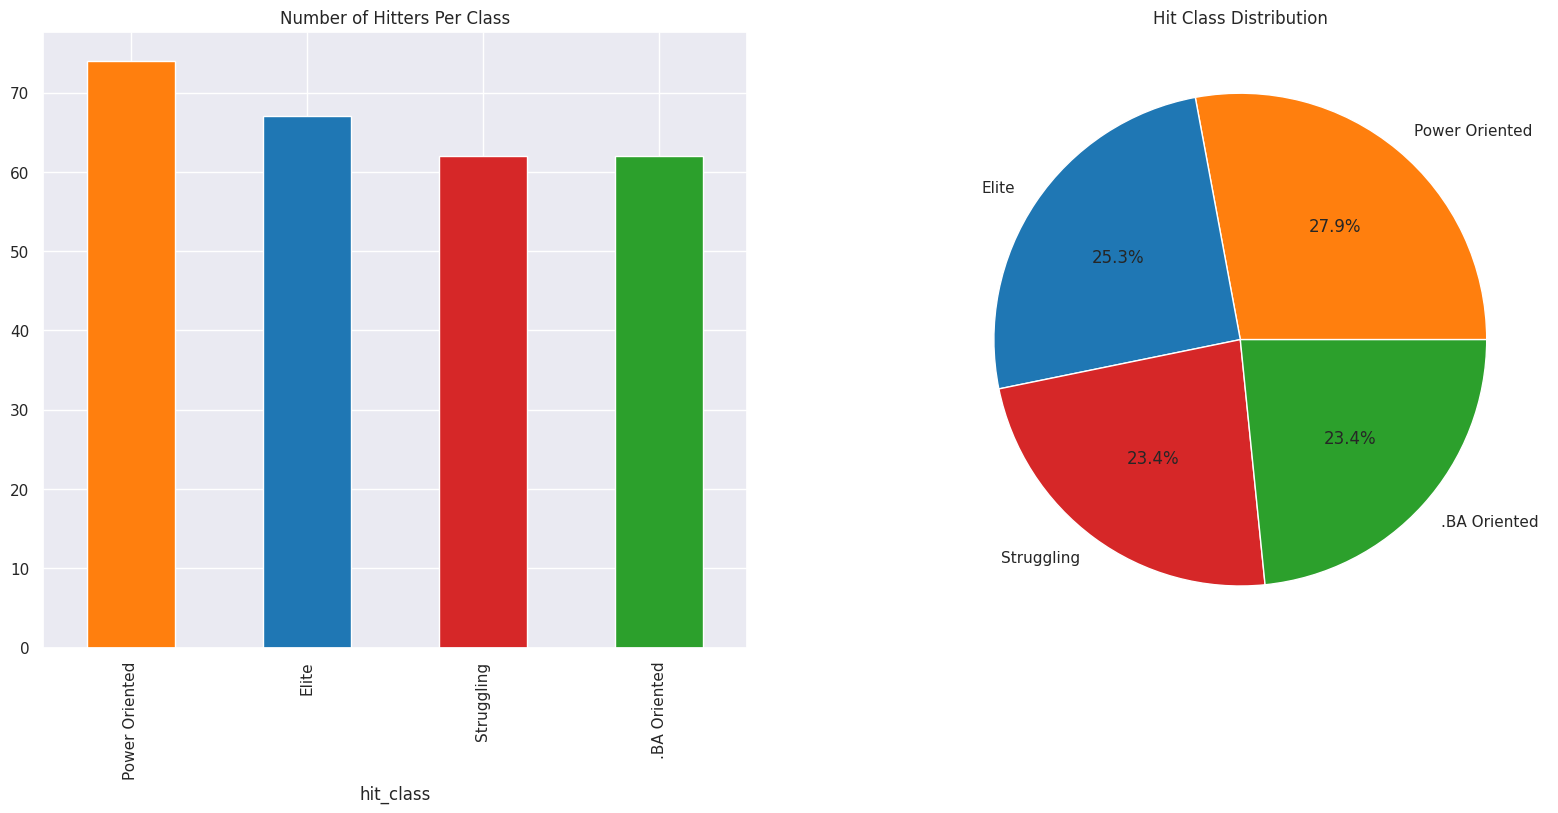

In [644]:
# Create Figure / Base for Subplots
fig, ax = plt.subplots(figsize = (20,20))

# Add Axes and Individual Grids - Subplot Grids
ax1 = plt.subplot2grid(shape=(1,2), loc=(0,0))
ax2 = plt.subplot2grid(shape=(1,2), loc=(0,1))


# Colors for Plots
colors = ['tab:orange', 'tab:blue', 'tab:red', 'tab:green']


# Plot distribution of Hit classes
ax1 = grouped['hit_class'].value_counts().plot(kind = 'bar', figsize = (20, 8), ax=ax1, color = colors, title = 'Number of Hitters Per Class')
ax2 = grouped['hit_class'].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=ax2, colors = colors, title = 'Hit Class Distribution')
ax2.set_ylabel('') 

**INSIGHTS & IMPLICATION ON ANALYSIS:**

Analyzing the subplots, it becomes clear of how **balanced** the league is in terms of each hitting class. This demonstrates how mixed players are in their hitting philosiphies and approach, with there not being a singular preferred approach. It may also demonstrate the **ranging skills** of players within the league, with average bat speeds being quite spread out across the league. Even despite this fact, there is a **still a slight preference for power-oriented hitting**, as demonstrated by the 27.9% share for 'Power Oriented' hitters. This should be of minimal surprise as the league has trended in this direction for quite some time. 

Nonetheless, these plots are only a surface-level view of these distributions. As I progress into my analysis, I'll delve further into how rosters / lineups are constructed around these different hitting classes.

# Data Exploration - Analyzing The Hitting Classes And Their Features

To further analyze the hit classes I created, I focused on answering the following questions:

## *On average, what does the bat speed distribution for these groups look like? Are there groups which have larger / smaller distributions in bat speed?*

To begin, I wanted to investigate the speed distribution per hitting classification. This would allow us to see by how much each hitting classification may range in bat speed, providing for some interesting insights on how these groups vary in their range of avg. bat speed.

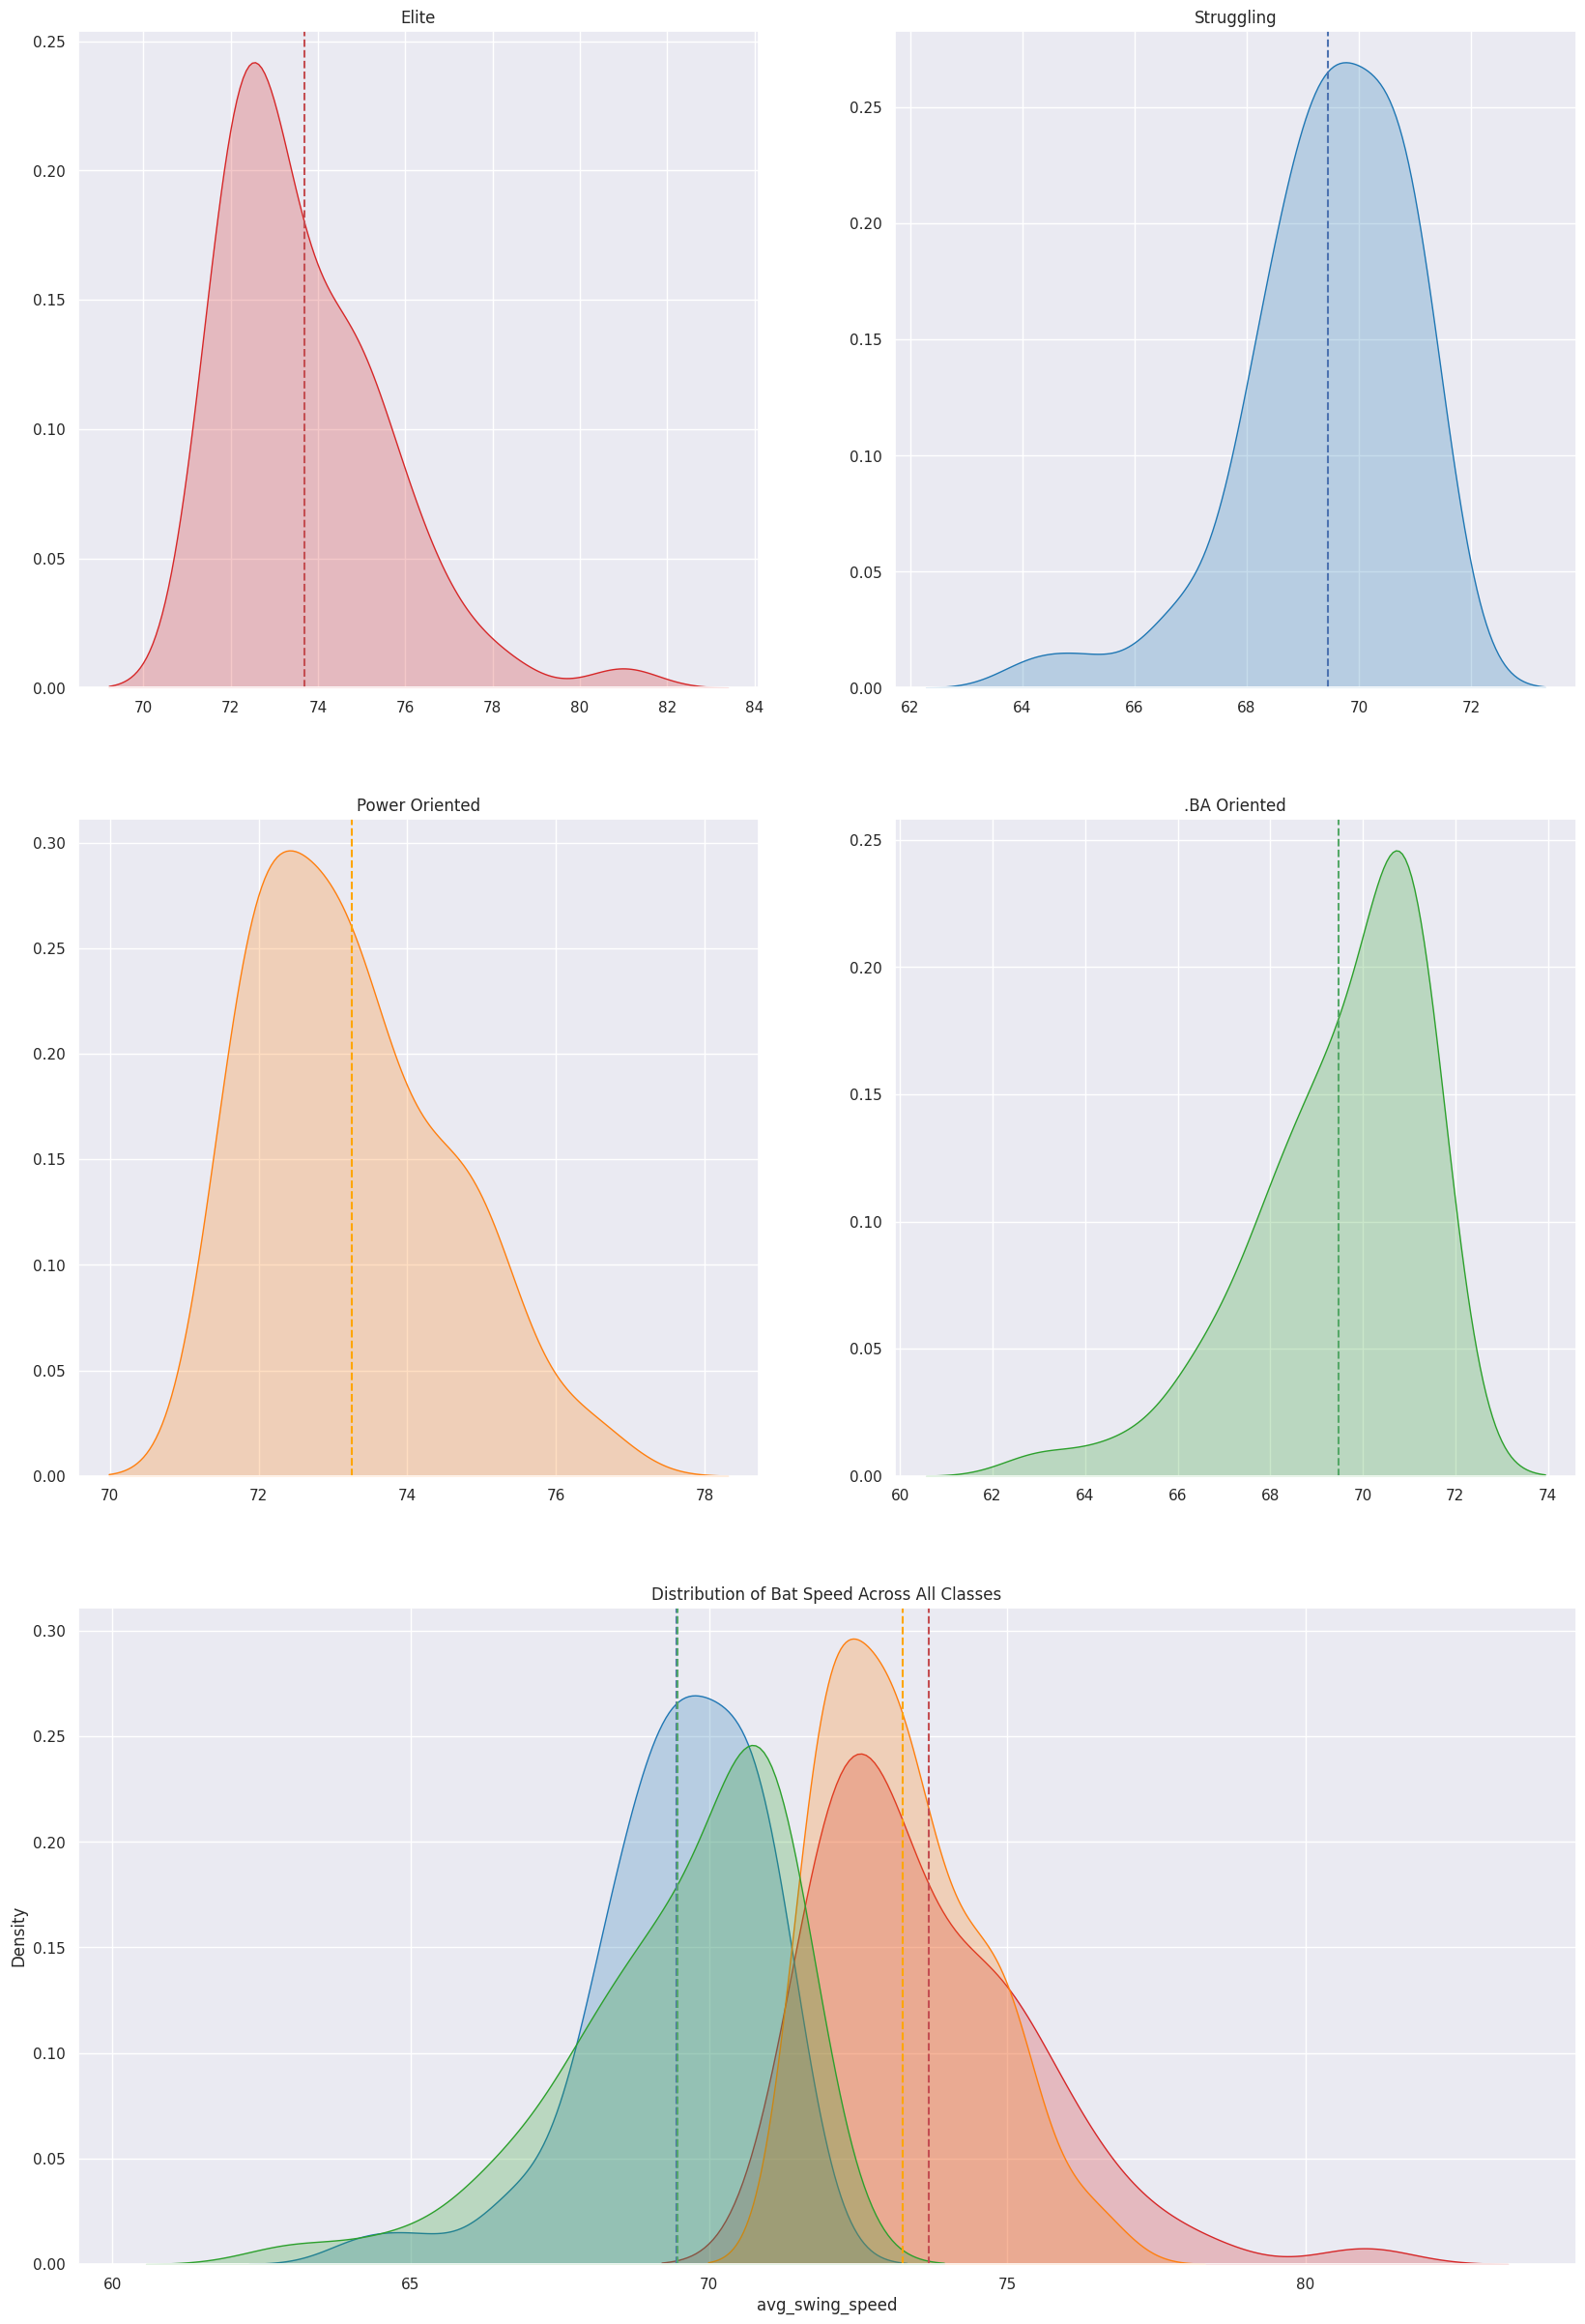

In [645]:
# Create Figure / Base for Subplots
fig, ax = plt.subplots(figsize = (20, 30))

# Add Axes and Individual Grids - Subplot Grids
ax1 = plt.subplot2grid(shape=(3,2), loc=(0,0))
ax2 = plt.subplot2grid(shape=(3,2), loc=(0,1))
ax3 = plt.subplot2grid(shape=(3,2), loc=(1,0))
ax4 = plt.subplot2grid(shape=(3,2), loc=(1,1))
ax5 = plt.subplot2grid(shape=(3,1), loc=(2,0))


# INDIVIDUAL GRIDS (ax1 through ax4)

# 'Elite' Distribution
Elite = grouped[grouped['hit_class'] == "Elite"]
sns.set(rc={'figure.figsize':(10,5)})
ax1 = sns.kdeplot(Elite['avg_swing_speed'], fill = True, ax=ax1, color = 'tab:red')
ax1.set_title('Elite')
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.axvline(x=np.mean(Elite['avg_swing_speed']), color='r', linestyle='--')
# 'Struggling' Distribution
Struggling = grouped[grouped['hit_class'] == "Struggling"]
ax2 = sns.kdeplot(Struggling['avg_swing_speed'], fill = True, ax=ax2, color = 'tab:blue')
ax2.set_title('Struggling')
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.axvline(x=np.mean(Struggling['avg_swing_speed']), color='b', linestyle='--')
# 'Power Oriented' Distribution
PO = grouped[grouped['hit_class'] == "Power Oriented"]
ax3 = sns.kdeplot(PO['avg_swing_speed'], fill = True, ax=ax3, color = 'tab:orange')
ax3.set_title('Power Oriented')
ax3.set_xlabel('')
ax3.set_ylabel('')
ax3.axvline(x=np.mean(PO['avg_swing_speed']), color='orange', linestyle='--')
# '.BA Oriented' Distribution
BA = grouped[grouped['hit_class'] == ".BA Oriented"]
ax4 = sns.kdeplot(BA['avg_swing_speed'], fill = True, ax=ax4, color = 'tab:green')
ax4.set_title('.BA Oriented')
ax4.set_xlabel('')
ax4.set_ylabel('')
ax4.axvline(x=np.mean(BA['avg_swing_speed']), color='g', linestyle='--')


# All hit classes in One Graph (ax5)
sns.kdeplot(Elite['avg_swing_speed'], fill = True, ax=ax5, color = 'tab:red')
sns.kdeplot(Struggling['avg_swing_speed'], fill = True, ax=ax5, color = 'tab:blue')
sns.kdeplot(PO['avg_swing_speed'], fill = True, ax=ax5, color = 'tab:orange')
sns.kdeplot(BA['avg_swing_speed'], fill = True, ax=ax5, color = 'tab:green')
ax5.set_title('Distribution of Bat Speed Across All Classes')
ax5.axvline(x=np.mean(Elite['avg_swing_speed']), color='r', linestyle='--')
ax5.axvline(x=np.mean(Struggling['avg_swing_speed']), color='b', linestyle='--')
ax5.axvline(x=np.mean(PO['avg_swing_speed']), color='orange', linestyle='--')
ax5.axvline(x=np.mean(BA['avg_swing_speed']), color='g', linestyle='--')

**INSIGHTS & IMPLICATIONS:**
* Each classification **peaks around the 71-72 mph** area in bat speed (which is the average bat speed noted earlier).
* .BA Oriented hitters varied the most in average bat speed, having a **12-14 mph range**. This implicates that .BA oriented hitters can experience success with even avg. bat speeds as low as 60 mph, with others experience success close to the 72 mph average. Thus, the variance within this group is much more apparent than others. Despite this, its important to note how a majority of these hitters were above 68 mph, implicating the importance of a relatively higher bat speed.
* Elite hitters had a **10-12 mph range** in average bat speed, remaining around 71mph - 80mph in terms of their range. Most hitters sat around the 72 - 76 mph level, with a few hitters getting close to the 80 mph threshhold.
* Struggling hitters had an approx. **10 mph range** in terms of bat speed (the second largest of any classification). This is likely due to the abnormally low bat speed which some of these players within this classification have (around 64 mph), resulting in the wider range noted. Interestingly, this groups distribution had higher density levels at extremely low bat speed levels (approx. 64 mph). This implicates how this group includes several extremely low bat speed hitters, while also having a decent amount of 70+ mph hitters that just happen to hit below average (once again, we'll explore these ideas further in a later section)
* Power oriented hitters had a **~8 mph range** in average bat speed. There was a strong concentration around the 72 - 74 mph level, being a bit lower than our 'Elite' hitters category.

## *How do batting classes rank in terms of different batting metrics?*

With our baselines established for each hitting category, let's analyze how each group ranks in terms of different hitting metrics.

Text(0.5, 1.0, 'Whiff %')

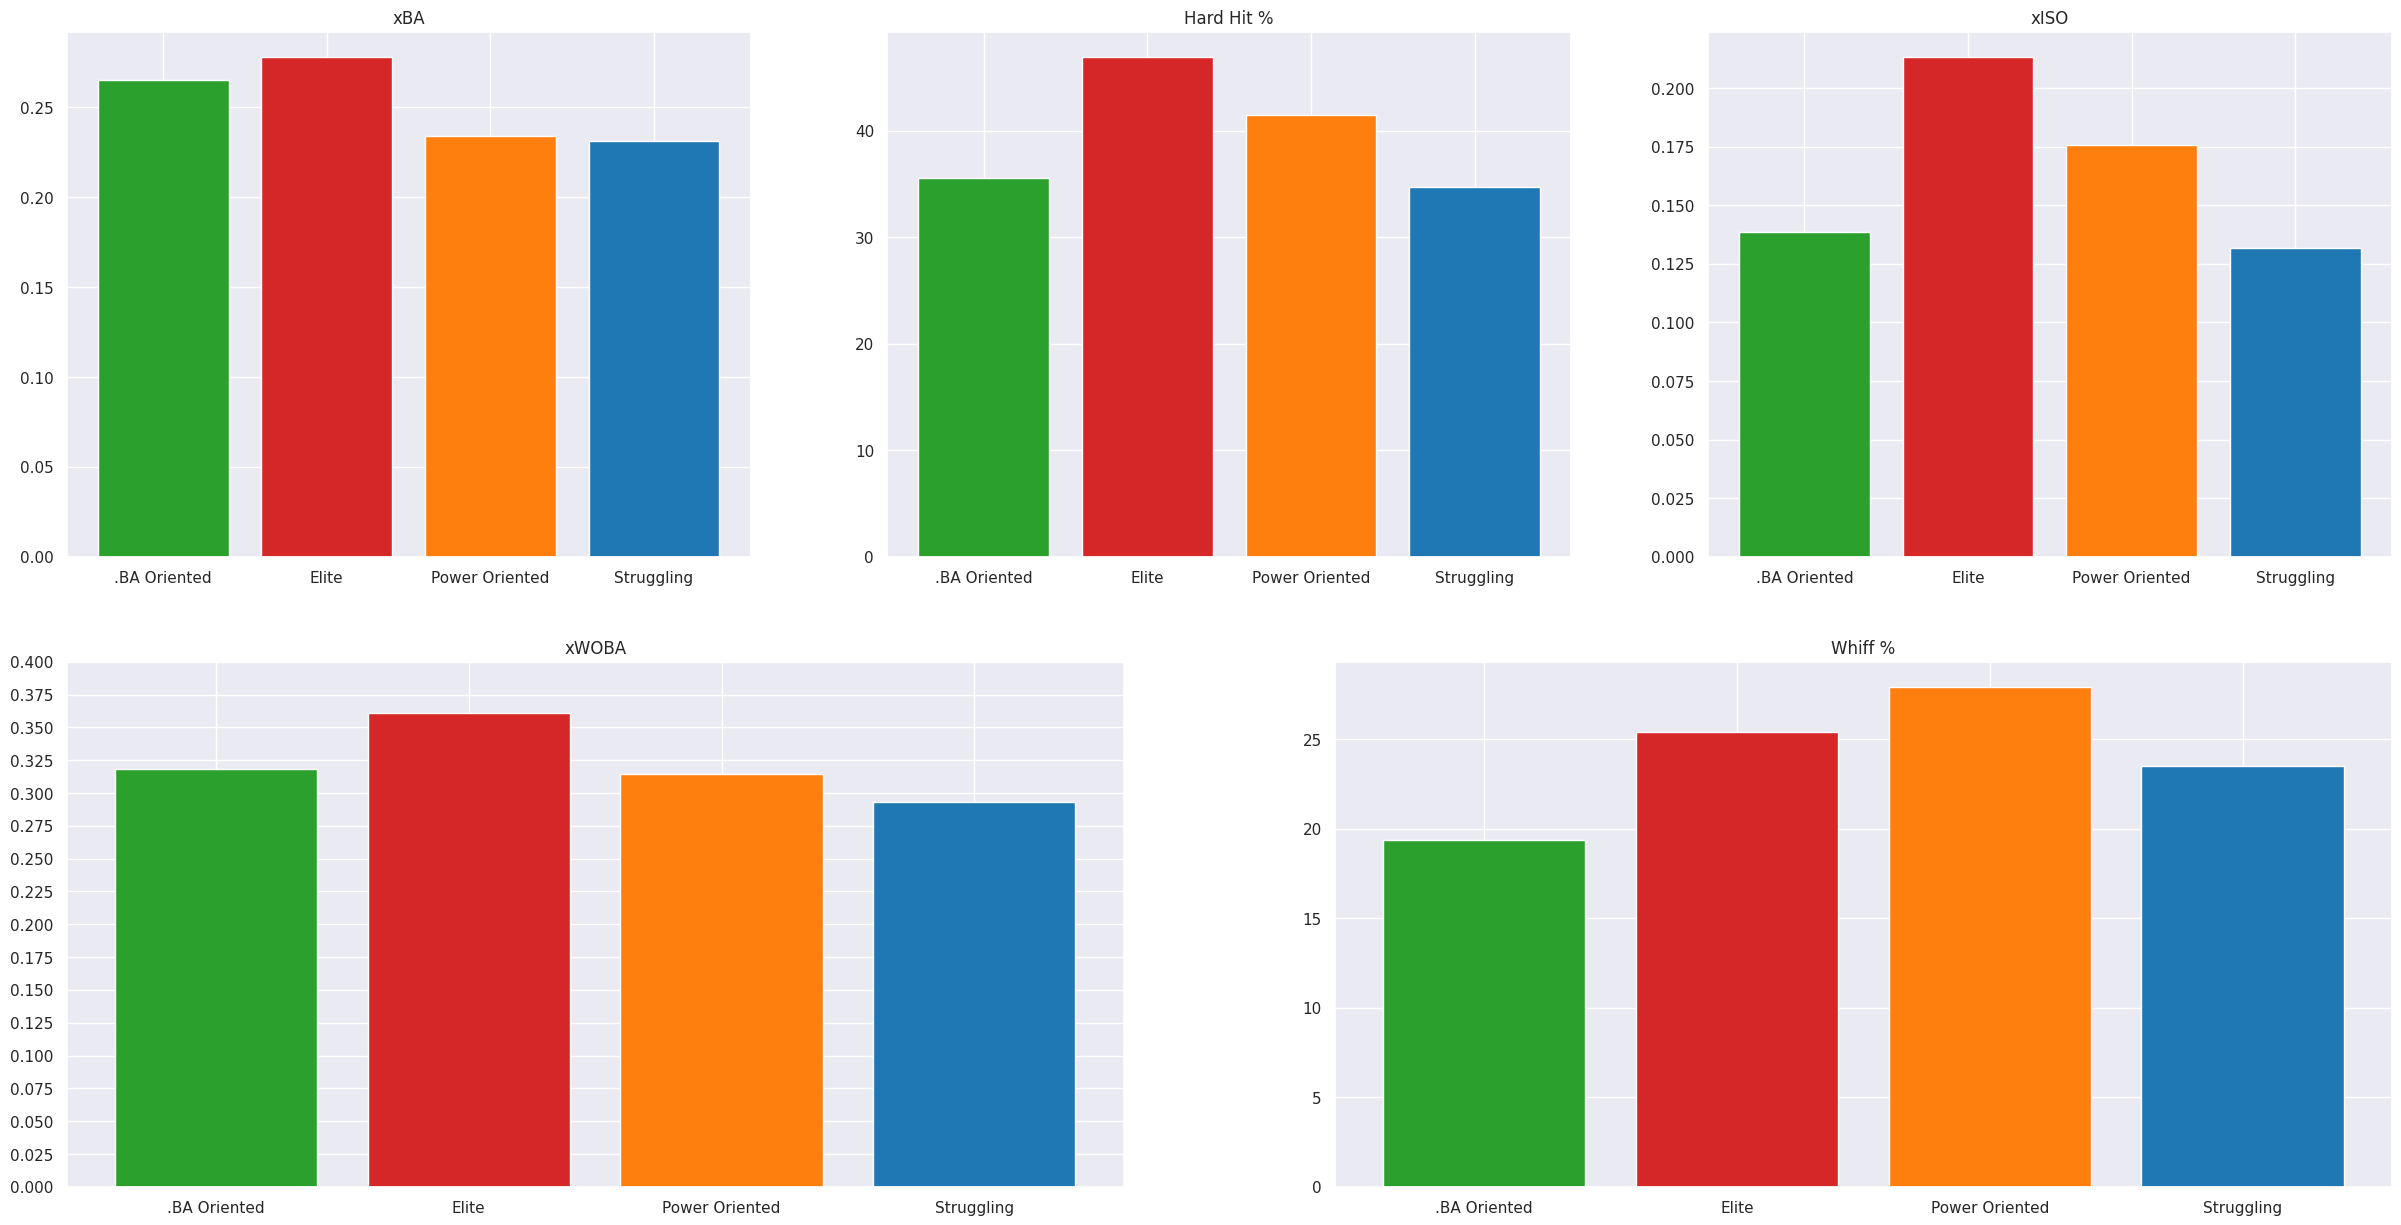

In [646]:
# Create Figure / Base for Subplots
fig, ax = plt.subplots(figsize = (30,15))

# Add Axes and Individual Grids - Subplot Grids
ax1 = plt.subplot2grid(shape=(2,3), loc=(0,0))
ax2 = plt.subplot2grid(shape=(2,3), loc=(0,1))
ax3 = plt.subplot2grid(shape=(2,3), loc=(0,2))
ax4 = plt.subplot2grid(shape=(2,2), loc=(1,0))
ax5 = plt.subplot2grid(shape=(2,2), loc=(1,1))


# Define a color map for the 'hit_class' categories
color_map = {'Struggling':'tab:blue', 'Elite':'tab:red', 'Power Oriented':'tab:orange', '.BA Oriented':'tab:green'}


# Build out subplots

# xBA
agg_grouped = grouped.groupby('hit_class').agg({'xba': 'mean'}).reset_index()
bars = ax1.bar(agg_grouped['hit_class'], agg_grouped['xba'], color=[color_map[hit_class] for hit_class in agg_grouped['hit_class']])
ax1.set_title('xBA')

# Hard Hit Percent
agg_grouped2 = grouped.groupby('hit_class').agg({'hard_hit_percent': 'mean'}).reset_index()
bars = ax2.bar(agg_grouped2['hit_class'], agg_grouped2['hard_hit_percent'], color=[color_map[hit_class] for hit_class in agg_grouped2['hit_class']])
ax2.set_title('Hard Hit %')

# xISO
agg_grouped3 = grouped.groupby('hit_class').agg({'xiso': 'mean'}).reset_index()
bars = ax3.bar(agg_grouped3['hit_class'], agg_grouped3['xiso'], color=[color_map[hit_class] for hit_class in agg_grouped3['hit_class']])
ax3.set_title('xISO')

# xwOBA
agg_grouped4 = grouped.groupby('hit_class').agg({'xwoba': 'mean'}).reset_index()
bars = ax4.bar(agg_grouped4['hit_class'], agg_grouped4['xwoba'], color=[color_map[hit_class] for hit_class in agg_grouped4['hit_class']])
ax4.set_title('xWOBA')
# Set y-axis intervals to 0.025
y_min, y_max = ax4.get_ylim()
ax4.set_yticks(np.arange(y_min, y_max + 0.025, 0.025))  # Adjust interval to 0.025


# Whiff Percent
agg_grouped5 = grouped.groupby('hit_class').agg({'whiff_percent': 'mean'}).reset_index()
bars = ax5.bar(agg_grouped5['hit_class'], agg_grouped5['whiff_percent'], color=[color_map[hit_class] for hit_class in agg_grouped5['hit_class']])
ax5.set_title('Whiff %')

**INSIGHTS & IMPLICATIONS:**
* **xBA**: As expected, 'Elite' and '.BA Oriented' hitters lead this category with 'Elite' hitters having a slight edge. There is an approx. 0.04 xBA drop off until the next two categories, where 'Power Oriented' just barely takes the lead over 'Struggling' hitters.  
* **Hard Hit %**: The two to classes in 'Power Oriented' and 'Elite' have Hard Hit %s and above 40%, with '.BA oriented' and 'Struggling' hitters falling around 35%.
* **xISO**: 'Elite' has a significant lead in this category, exceeding 'Power Oriented' hitters (2nd highest category) by approx 0.3 in xISO. The drop-off from these categories is quite significant, with '.BA Oriented' and 'Struggling' hitters having ISO values just around the 0.13 mark
* **xWOBA**: Once again, 'Elite' hitters have a significant lead in this metric (leads the next highest hitting class by approx. 0.05 xWOBA points). However, the most interesting fact is that '.BA oriented' hitters just barely beat out 'Power Oriented' hitters by approx. 0.01 xWOBA points. While this is not enough to conclude that '.BA Oriented' hitters are more 'valuable' in terms of their offensive production, its an interesting point worth following-up as I progress with my analysis.
* **Whiff %**: 'Power Ortiented' and 'Elite' hitters lead this metric by a significant margin, 3-5% above the next highest category. On the other hand, '.BA Oriented' hitters had significantly lower whiff rates (~10% lower than 'Elite', 'Power Oriented'). This indicates that players with higher bat speeds will resort to more aggressive batting approaches (on average), resulting in the higher number of whiffs noted. 

**Overall:** 'Elite' hitters are the most valuable in offensive production, without a doubt. However, the debate between '.BA Oriented' and 'Power Oriented' hitters is much more subjective. '.BA Hitters' have the slight lead in xWOBA, a stat seen as an all-encompassing method of evaluation for offensive production. Despite this, it's still difficult to ignore the lead which 'Power Oriented' hitters have in xISO and hard hit %. As we're looking at a very surface level assessment of the two categories, it would be unfair to conclude on whether one class is superior to the other. In fact, we may find out that each class has its place within an offensive lineup, ultimately being dependent on how a team chooses to construct its batting lineup. Certain classifications may also perform better in different scenarios, once again deterring from the insights I've just arrived at. As such, I'll continue my analysis by observing pitch-level data & analyzing roster/lineup construction by hit class in the following sections. The insights I've derrived in this section will be used as more of a baseline, providing as reference for any notable trends we may notice later on. 

It's also worth mentioning how ineffective 'Struggling' hitters are in comparison to the rest of the other hitters. They are practically the worst in all of the categories we examined in this chart above, exemplifying how replacable these hitters potentially are. As I progress into my analysis, I will want to question why this group struggles so much and whether their performance could be further optimized. 

## *How does swing length look for each group?*

Now that we've established the importance of bat speed and its implication on hitting performance, we should now investigate some of the factors which influence bat speed (potentially). As such, I decided to analyze how swing length is distributed among the different hitting classifications.

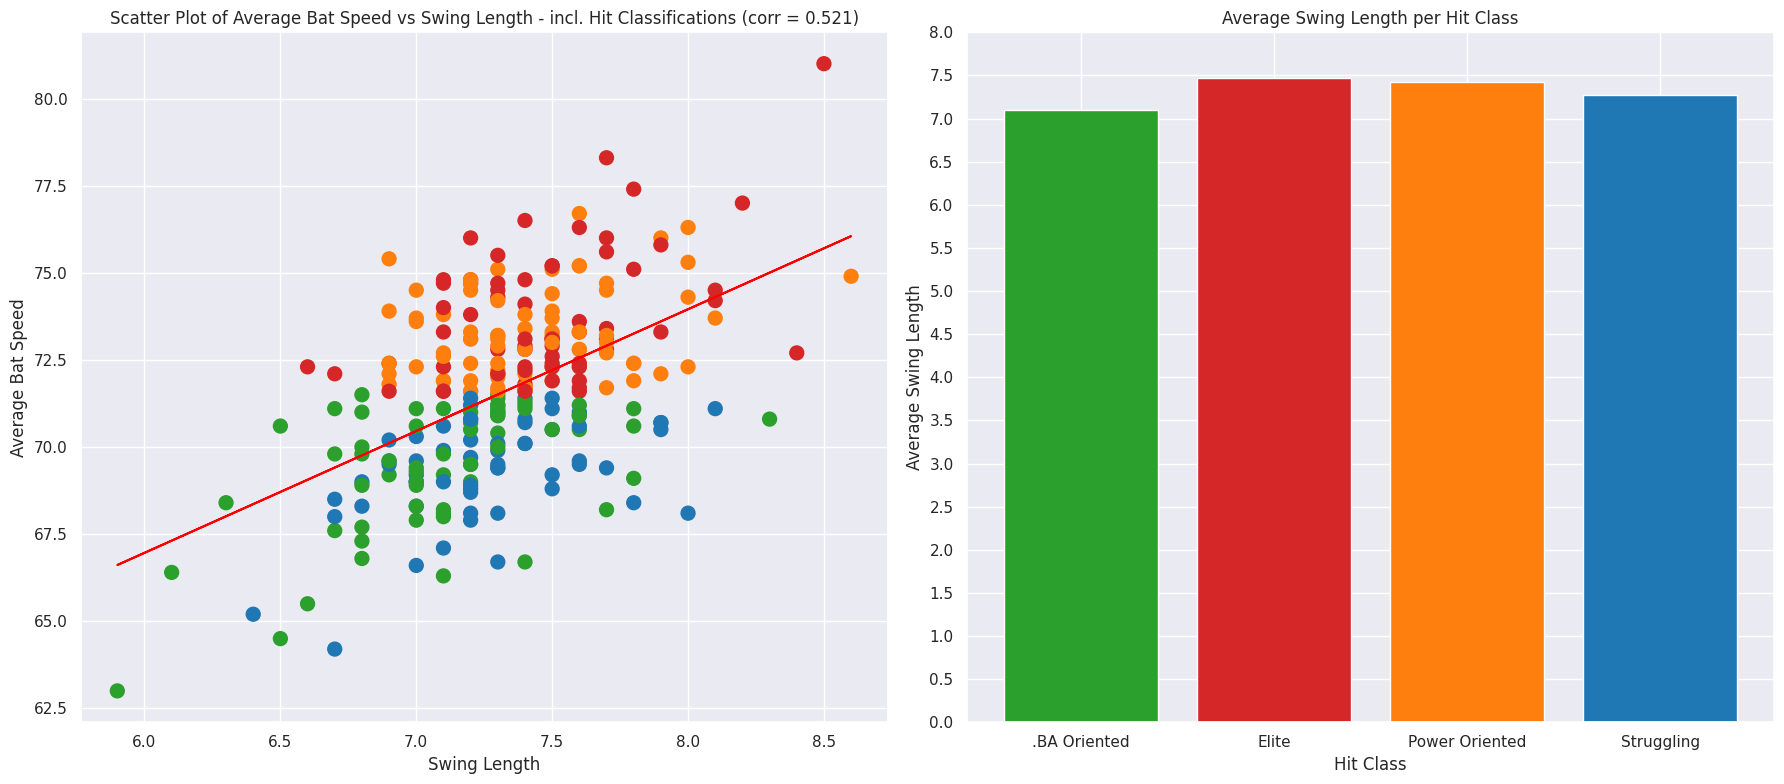

In [647]:
# Create Base for Plot
fig, ax = plt.subplots(figsize=(18, 8))

# Build out the Grid
ax1 = plt.subplot2grid(shape=(1, 2), loc=(0, 0))
ax2 = plt.subplot2grid(shape=(1, 2), loc=(0, 1))

# Define a color map for the 'hit_class' categories
color_map = {'Struggling': 'tab:blue', 'Elite': 'tab:red', 'Power Oriented': 'tab:orange', '.BA Oriented': 'tab:green'}

# Grid 1 - Swing Length Scatter Plot, y = bat speed  x = swing length
# Map the 'hit_class' values to colors
colors = grouped['hit_class'].map(color_map)

# Create the scatter plot
ax1.scatter(grouped['avg_swing_length'], grouped['avg_swing_speed'], color=colors, s=100)
ax1.set_xlabel('Swing Length')
ax1.set_ylabel('Average Bat Speed')
ax1.set_title('Scatter Plot of Average Bat Speed vs Swing Length - incl. Hit Classifications (corr = 0.521)')
ax1.grid(True)

# Plot a trend line
# Calculate the trend line (linear regression)
coefficients = np.polyfit(grouped['avg_swing_length'], grouped['avg_swing_speed'], 1)  # Fit a 1st degree polynomial (linear)
polynomial = np.poly1d(coefficients)
trendline = polynomial(grouped['avg_swing_length'])
# Plot the trend line
ax1.plot(grouped['avg_swing_length'], trendline, color='red', label='Trend line')

# Grid 2 - Average Swing Length per Hit Class
agg_grouped = grouped.groupby('hit_class').agg({'avg_swing_length': 'mean'}).reset_index()
ax2.bar(agg_grouped['hit_class'], agg_grouped['avg_swing_length'], color=[color_map[hit_class] for hit_class in agg_grouped['hit_class']])
ax2.set_title('Average Swing Length per Hit Class')
ax2.set_xlabel('Hit Class')
ax2.set_ylabel('Average Swing Length')
# Set y-axis intervals to 0.5
y_min, y_max = ax2.get_ylim()
ax2.set_yticks(np.arange(y_min, y_max + 0.5, 0.5))  # Adjust interval to 0.5

# Display the plot
plt.tight_layout()
plt.show()


**INSIGHTS & IMPLICATIONS:**

There are a few things we can note from the plots above:
* There is **a somewhat strong, positive assosciation between swing length and bat speed**.
* **'.BA Oriented' hitters have shorter swing lengths**, being near the 7.0 mark. Compact swing lengths likely allow them to hit for higher averages while sacrificing their power output (as we noted in the previous section with the lower ISO values, but significantly higher xBA values).
* **'Power Oriented' and 'Elite' hitters have longer swing lengths**, nearly reaching the 7.5 mark. Longer swings likely allow them to generate the higher power output we noted from them earlier (i.e., higher ISO values). 
* **'Struggling' hitters fall in the middle of all of the categories**, being around 7.3 mark. Perhaps, these hitters are struggling because they're lack of defined swing lengths and overall role in lineups? Or perhaps they're attempting to have a longer swing length to generate more power, but don't have the capibability to match this approach? These are just low-level theories, but I'll explore these ideas as I progress.

## *Pitch-level Analysis: How does batting class perform against different pitches? Different Handed Pitchers? Other Features?*

To extract further insights regarding each hitting classification, its important to analyze performance at the pitch-level.

Rather than building out several subplots, I decided to create a series of interactive dashboards on Tableau: https://public.tableau.com/app/profile/jalal.zaheed/viz/Pitch-levelInsights-MLBBatSpeedAnalysisbyJalalZaheed/HitClassDashboard

Using this dashboard, I derived the following **3 key insights**:

### **4-Seam Fastballs:**  The 4-seamer is the most commonly thrown pitch in the MLB in 2024. How does each classification perform?

*Top Of The Zone 4-Seamers, LHP and RHP*

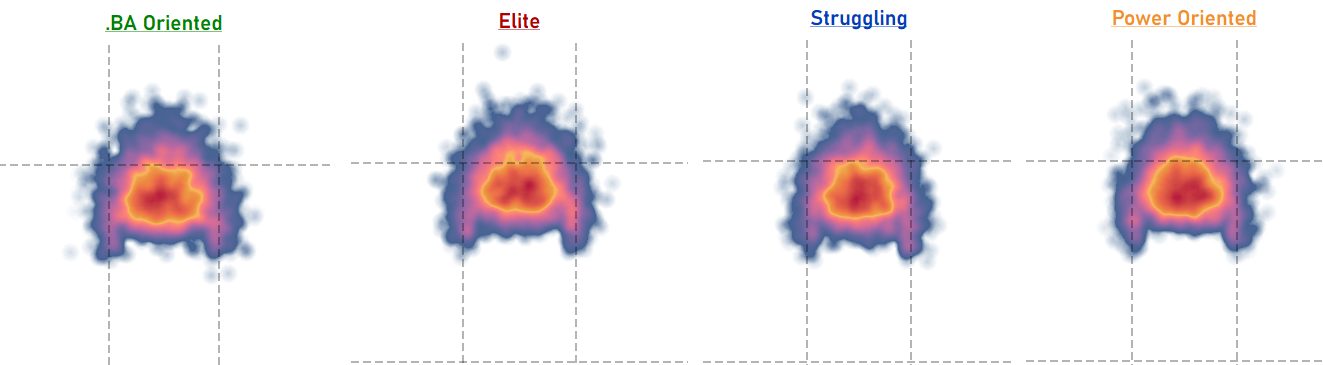

* **ANALYSIS:** All classifications seem to perform well against 4-seamers at the top of the zone (gameday zones 1,2,3,11,12). **'.BA oriented' hitters have the most coverage of this zone** (as evidenced by the greater coverage in their plot relative to other categories), simultaneously generating plenty of above-average launch speeds (evidenced by the concentration of dark-red zones). 'Power oriented' hitters performed similarly, but had less spread in these attack zones (smaller area overall). While it's difficult to distinguish, 'Power oriented' hitters seemingly generate the most above-average launch speeds of all categories by a slim margin (greater concentration of dark red zones relative to other categories). 'Elite' hitters has similar levels of coverage to 'Power oriented' hitters, but **noticeably had a lower concentration of dark red zones** (less above-average launch speeds generated). Despite this, 'Elite' hitters noticeably generated better launch speeds above the strike zone (evidenced through the yellow zone above the top of the strike zone). There isn't much to note for 'Struggling' hitters as they performed somewhat similar to the other groups in this category.
* **IMPLICATION:** Each category is pretty comperable when facing high-fastballs, having high concentrations of above average launch speeds within this zone. However, it's suprising to see how '.BA Oriented' hitters experienced similar launch speeds (possibly even better) to the other groups in this category.


### **Sinkers**:  Sinkers are another commonly thrown pitch in the MLB. How has each classification performed against them?

*Bottom Of The Zone Sinkers, LHP and RHP*

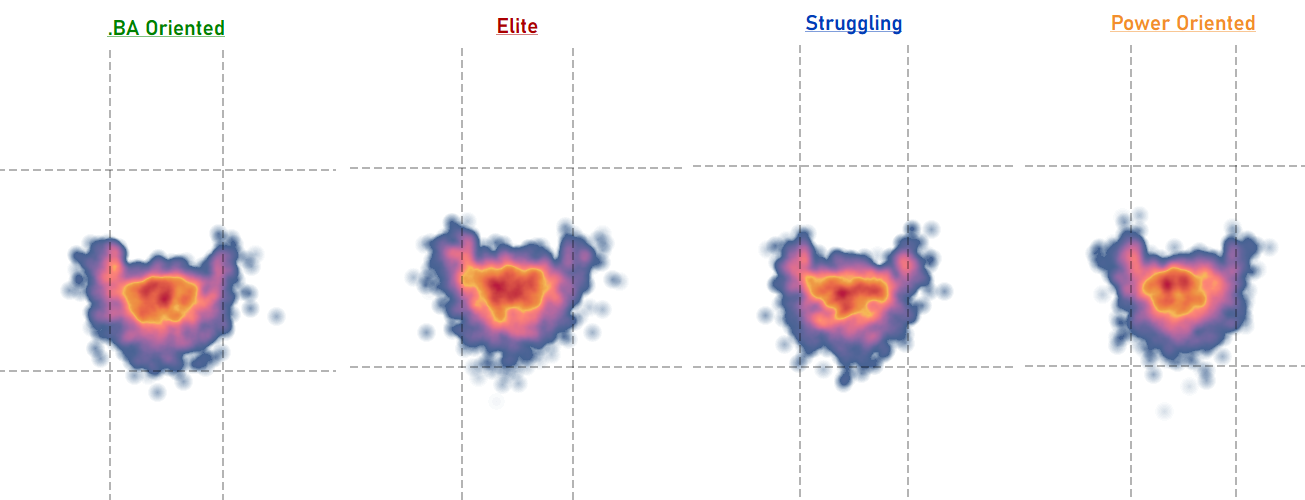

* **ANALYSIS:** Focusing on sinkers lower in the strike zone (gameday zones 7,8,9,13,14), **'Elite' hitters excelled compared to other categories**. Not only does this group have the largest yellow shadow (i.e., most average - above average launch speeds), but it also has the strongest conentration of dark red zones (most above average launch speeds in this zone). This demonstrates 'Elite' hitters ability to maintain average - above average launch speeds across the whole zone, including the left part of the plate (inside to RH batters, outside for LH batters). '.BA Oriented' and 'Struggling' hitters follow-up behind 'Elite', with '.BA Oriented' hitters having a relatively lower amount of dark red zones (less above average launch speeds), but having a greater overall spread and yellow shadow (e.g., more average to above average launch speeds). 'Power Oriented' hitters peform the worst in this zone, semeingly having the smallest shadows and the least amount of dark red zone concentration of all the categories. It noticeably is limited to the middle part of the zone, with its launch speeds dropping off towards the outside parts of the zone. 
* **IMPLICATION:** Unlike their performance against 4-seamers, **'Elite' hitters have distinguished themselves** in their performance against sinkers. Not only does this group demonstrate an ability to experience above-average or top level launch speeds, but it also shows an ability to maintain average launch speeds throughout the entire zone (moreso than '.BA Oriented hitters). Effectively, 'Elite' hitters are able to perform better than other categories on sinkers that tail towards the inside/outside parts of the plate. On the other hand, it's interesting to note how poor 'Power Oriented' hitters performed against this pitch (relative to other groups). Compared to their performance against 4-seamers, this is a bit of a drop-off.

### **Sliders:** Sliders have become one of the most frequently thrown breaking balls in the game. How has each classification fared against them?

*Bottom Of The Zone Sliders, LHP and RHP*


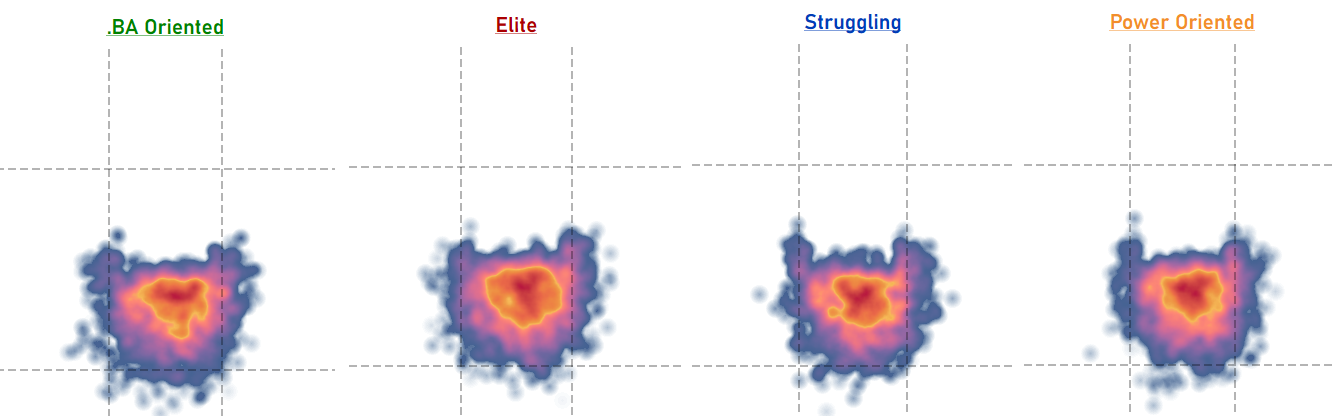

* **ANALYSIS:** As evidenced by the heat zones above, its evident that 'Elite' hitters have an advantage when facing sliders near the bottom of the zone. This group maintains above average launch speeds against this pitch (as by the concentration of dark red zones relative to other categories), while also maintaing better overall launch speeds across the entire zone (shown by its larger yellow shadow relative to other groups). '.BA Oriented' hitters also do a decent job when attacking this pitch, having a similar launch speeds on the outside of the zone to 'Elite' hitters. 'Power Oriented' hitters do experience a decent amount of above average launch speeds against this pitch, but noticeably are unable to maintain as effective launch speeds on the outskirts of the zone (their yellow shadow is noticeably smaller than other groups). A similar insight could also be applied to the 'Struggling' category.
* **IMPLICATION:** Against sliders, 'Elite' and '.BA Oriented' have the more favourable matchups, with 'Elite' being the most favourable of any category (mostly due to its balance of average launch speeds on the outside parts of the zone, and strong concentration of above average launch speeds in the middle of the zone). On the other hand, 'Power Oriented' and 'Struggling' hitters are not as favourable. While they may maintain above average launch speeds against middle-middle sliders, their performance beyond this range is worse in comparison to the other categories.

### **NOTE**: This is a condensed version of my pitch-level analysis. Please see my presentation for a detailed & thorough analysis!

### **Conclusion & Summary**

* 'Elite' classifications don't earn their status by how well they hit 4-seamers in comparison to other categories, rather they earn it by their ability to **maintain average - above average launch speeds against various types of pitches**, including **breaking balls** (i.e., sliders, changeups, etc.). As demonstrated through the heat charts included (within this notebook & my presentation), 'Elite' hitters consistently had the best launch speeds against breaking balls or any secondary pitches. Being effective against these secondary pitches is what makes them so effectively, likely winning more of the 1-on-1 matchups because of this ability. While '.ba oriented' and 'power oriented' hitters bring their own strengths against these pitches, 'Elite' hitters are effectively the perfect combination of these classes. They not only maintain average launch speeds across more of the zone (like '.ba oriented' hitters are effective at doing), but they often have the most above-average launch speeds across the zones (as shown by their concentrations of dark-red areas). Due to this, 'Elite' hitters are able to generate the higher performance metrics we noted earlier (xISO, xBA, xWOBA).
* **'Power oriented' and '.BA Oriented'** hitters have their individual uses. By this, I mean that each hitting category has their own advantages against certain matchups. As shown by the visualizations, 'Power Oriented' hitters are far more effective than any class in generating above average launch speeds. This is especially true for fastballs and breaking pitches, mainly having the advantage when these pitches are thrown towards the middle of the zone. To optimize these hitters values, its best to place them in matchups against pitchers who have limited arsenals or higher fastball usage rates. It may also be worth pitting them against pitchers with higher mistake pitch rates (i.e., higher meatball %, etc.), allowing these hitters to capitalize on such mistakes should they occur. On the other hand, '.BA Oriented' hitters will likely perform better against pitchers who use the corners effectively or whom have more complex arsenals (i.e., plenty of breaking balls, other secondary pitchers). Not only has this group shown an ability to maintain average launch speeds in the corners of the zone, but it also has an ability to square-up complex breaking-balls better than other hit clases. It's also worth mentioning how this group has the lowest whiff rates of all the classifications, likely indicating better discipline at the plate (the type of approach which may be more favourable against more complex pitcher arsenals). 
    * **REMINDER**: Ultimately, the way you use these players is dependent on their personal variables & performance. It also depends on the individual players they are matching up against, as well as the attributes of the pitchers arsenals. As such, these insights are meant as more of a guiding factors rather than legitimate suggestions.

I understand that some of these insights may same somewhat intuitive, but its important that we establish these insights through the data presented. Without such presentation, it make it difficult to try and legitimize these claims. Simultaneously, performing this analysis re-assures us of the thought processes and methodologies we may have in analyzing batter vs. pitcher 1-on-1 matchups.


# Roster & Lineup Construction-based Insights: Data Exploration & Modelling

Now that we've gotten an understanding for each individual hitting class, we should analyze how these classifications comprise individual MLB rosters. Through this analysis, I'll determine what is the **'ideal' batting lineup** for teams to model their offense (e.g., balanced lineup with all hitting classes, or just .BA Oriented and 'Elite' hitters?). 

In [648]:
# Load in roster dataset
rosters = pd.read_csv('/kaggle/input/rosters24/MLB Roster Data 0819.csv')
rosters.head()

,Name,Team,G,AB,PA,H,1B,2B,3B,HR,...,HBP,SF,SH,GDP,SB,CS,AVG,NameASCII,PlayerId,MLBAMID
0,Jacob Wilson,OAK,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,1.000000,Jacob Wilson,33266,805779
1,Will Wagner,TOR,5,15,16,8,5,3,0,0,...,0,0,0,0,0,0,0.533333,Will Wagner,29634,695238
2,Samad Taylor,SEA,3,5,5,2,2,0,0,0,...,0,0,0,0,0,0,0.400000,Samad Taylor,22274,669392
3,Austin Wynns,CIN,7,19,20,7,3,4,0,0,...,1,0,0,0,0,0,0.368421,Austin Wynns,15271,642851
4,Grant McCray,SFG,4,14,15,5,2,2,0,1,...,0,0,0,0,0,0,0.357143,Grant McCray,25690,687529


## **Roster Construction Analysis:** What is the distribution of hitting classes across MLB Teams? Are there any noticeable trends?

We'll begin by analyzing how teams are constructing rosters based on these hitting classifications.

### **Data Cleaning**: Organizing & Applying Roster Data

Before any analysis can be done, we'll nead to apply our roster data to our own dataset. Following this, we'll need to clean up for any NA data that could disrupt our analysis.

In [649]:
# Merge the datasets using different column names for 'ID'
grouped = pd.merge(grouped, rosters[['MLBAMID', 'Team']], left_on='player_id', right_on='MLBAMID', how='left')

# Drop the 'MLBAMID' column if you don't need it in the final dataset
grouped = grouped.drop(columns=['MLBAMID'])

grouped.head()

,"last_name, first_name",player_id,year,pa,home_run,k_percent,bb_percent,xba,xslg,xwoba,...,whiff_percent,swing_percent,pull_percent,straightaway_percent,opposite_percent,groundballs_percent,flyballs_percent,linedrives_percent,hit_class,Team
0,"Blackmon, Charlie",453568,2024,372,8,16.9,8.3,0.246,0.361,0.301,...,18.7,48.6,44.0,35.2,20.9,38.8,25.3,23.8,Struggling,COL
1,"McCutchen, Andrew",457705,2024,437,16,26.1,11.7,0.237,0.443,0.340,...,29.1,41.8,38.1,41.9,20.0,41.9,27.2,21.9,Power Oriented,PIT
2,"Turner, Justin",457759,2024,395,7,18.5,10.6,0.248,0.373,0.324,...,17.1,45.2,40.4,34.8,24.8,34.8,29.3,28.5,Struggling,- - -
3,"Santana, Carlos",467793,2024,446,17,17.3,10.3,0.245,0.419,0.327,...,23.5,42.9,48.9,32.8,18.3,37.9,29.3,22.7,Struggling,MIN
4,"Pham, Tommy",502054,2024,350,7,20.6,8.6,0.282,0.433,0.341,...,22.0,40.7,35.4,37.0,27.6,43.1,20.7,30.5,Elite,- - -


Some of the players ended up being labeled as "- - -" as they moved teams during the year. As such, I needed to briefly clean up this data

In [650]:
# Filter for the players who changed teams
filtered = grouped[grouped['Team'] == "- - -"]
filtered

,"last_name, first_name",player_id,year,pa,home_run,k_percent,bb_percent,xba,xslg,xwoba,...,whiff_percent,swing_percent,pull_percent,straightaway_percent,opposite_percent,groundballs_percent,flyballs_percent,linedrives_percent,hit_class,Team
2,"Turner, Justin",457759,2024,395,7,18.5,10.6,0.248,0.373,0.324,...,17.1,45.2,40.4,34.8,24.8,34.8,29.3,28.5,Struggling,- - -
4,"Pham, Tommy",502054,2024,350,7,20.6,8.6,0.282,0.433,0.341,...,22.0,40.7,35.4,37.0,27.6,43.1,20.7,30.5,Elite,- - -
30,"Canha, Mark",592192,2024,412,7,21.1,10.9,0.214,0.310,0.289,...,22.5,41.7,42.9,35.4,21.6,49.3,21.6,22.4,Struggling,- - -
37,"Rosario, Eddie",592696,2024,319,10,24.1,5.0,0.212,0.345,0.259,...,27.4,52.9,43.4,30.5,26.1,40.3,32.3,23.5,Struggling,- - -
48,"Bell, Josh",605137,2024,504,18,19.4,7.7,0.240,0.409,0.310,...,27.0,50.4,39.4,31.9,28.6,46.9,25.6,21.1,Struggling,- - -
58,"Winker, Jesse",608385,2024,423,11,21.7,13.0,0.244,0.381,0.327,...,20.6,42.7,35.3,34.9,29.7,48.7,21.2,22.7,Struggling,- - -
74,"Soler, Jorge",624585,2024,447,16,24.8,11.9,0.248,0.450,0.346,...,29.1,45.1,44.2,33.5,22.3,36.3,29.5,24.5,Power Oriented,- - -
88,"Rosario, Amed",642708,2024,287,2,17.4,2.8,0.263,0.369,0.288,...,22.9,54.6,31.0,40.7,28.3,52.2,17.7,25.2,.BA Oriented,- - -
93,"Jansen, Danny",643376,2024,256,8,18.0,11.3,0.218,0.375,0.304,...,20.7,40.3,52.0,30.2,17.9,26.3,33.5,26.3,Struggling,- - -
94,"Kiner-Falefa, Isiah",643396,2024,334,7,14.1,4.2,0.253,0.354,0.291,...,13.9,45.3,32.1,40.0,27.9,46.0,22.3,25.7,.BA Oriented,- - -


In [651]:
# Update the 'Team' column in the grouped DataFrame
grouped.loc[grouped['player_id'] == 457759, 'Team'] = 'SEA'
grouped.loc[grouped['player_id'] == 502054, 'Team'] = 'STL'
grouped.loc[grouped['player_id'] == 592192, 'Team'] = 'SFG'
grouped.loc[grouped['player_id'] == 592696, 'Team'] = 'ATL'
grouped.loc[grouped['player_id'] == 605137, 'Team'] = 'ARI'
grouped.loc[grouped['player_id'] == 608385, 'Team'] = 'NYM'
grouped.loc[grouped['player_id'] == 624585, 'Team'] = 'ATL'
grouped.loc[grouped['player_id'] == 642708, 'Team'] = 'LAD'
grouped.loc[grouped['player_id'] == 643376, 'Team'] = 'BOS'
grouped.loc[grouped['player_id'] == 643396, 'Team'] = 'PIT'
grouped.loc[grouped['player_id'] == 650333, 'Team'] = 'SDP'
grouped.loc[grouped['player_id'] == 650391, 'Team'] = 'BAL'
grouped.loc[grouped['player_id'] == 650559, 'Team'] = 'PIT'
grouped.loc[grouped['player_id'] == 657041, 'Team'] = 'CLE'
grouped.loc[grouped['player_id'] == 657557, 'Team'] = 'KCR'
grouped.loc[grouped['player_id'] == 664034, 'Team'] = 'CIN'
grouped.loc[grouped['player_id'] == 665862, 'Team'] = 'NYY'
grouped.loc[grouped['player_id'] == 666624, 'Team'] = 'TBR'
grouped.loc[grouped['player_id'] == 668227, 'Team'] = 'SEA'
grouped.loc[grouped['player_id'] == 669222, 'Team'] = 'CHW'
grouped.loc[grouped['player_id'] == 670623, 'Team'] = 'CHC'

With our dataset prepared, we can now proceed into our analysis:

In [652]:
grouped.head()

,"last_name, first_name",player_id,year,pa,home_run,k_percent,bb_percent,xba,xslg,xwoba,...,whiff_percent,swing_percent,pull_percent,straightaway_percent,opposite_percent,groundballs_percent,flyballs_percent,linedrives_percent,hit_class,Team
0,"Blackmon, Charlie",453568,2024,372,8,16.9,8.3,0.246,0.361,0.301,...,18.7,48.6,44.0,35.2,20.9,38.8,25.3,23.8,Struggling,COL
1,"McCutchen, Andrew",457705,2024,437,16,26.1,11.7,0.237,0.443,0.340,...,29.1,41.8,38.1,41.9,20.0,41.9,27.2,21.9,Power Oriented,PIT
2,"Turner, Justin",457759,2024,395,7,18.5,10.6,0.248,0.373,0.324,...,17.1,45.2,40.4,34.8,24.8,34.8,29.3,28.5,Struggling,SEA
3,"Santana, Carlos",467793,2024,446,17,17.3,10.3,0.245,0.419,0.327,...,23.5,42.9,48.9,32.8,18.3,37.9,29.3,22.7,Struggling,MIN
4,"Pham, Tommy",502054,2024,350,7,20.6,8.6,0.282,0.433,0.341,...,22.0,40.7,35.4,37.0,27.6,43.1,20.7,30.5,Elite,STL


### **Roster Construction Analysis**: Deriving Insights 

**NOTE:** All of the visualizations are **ordered by Team xWOBA values as of August 18th.**

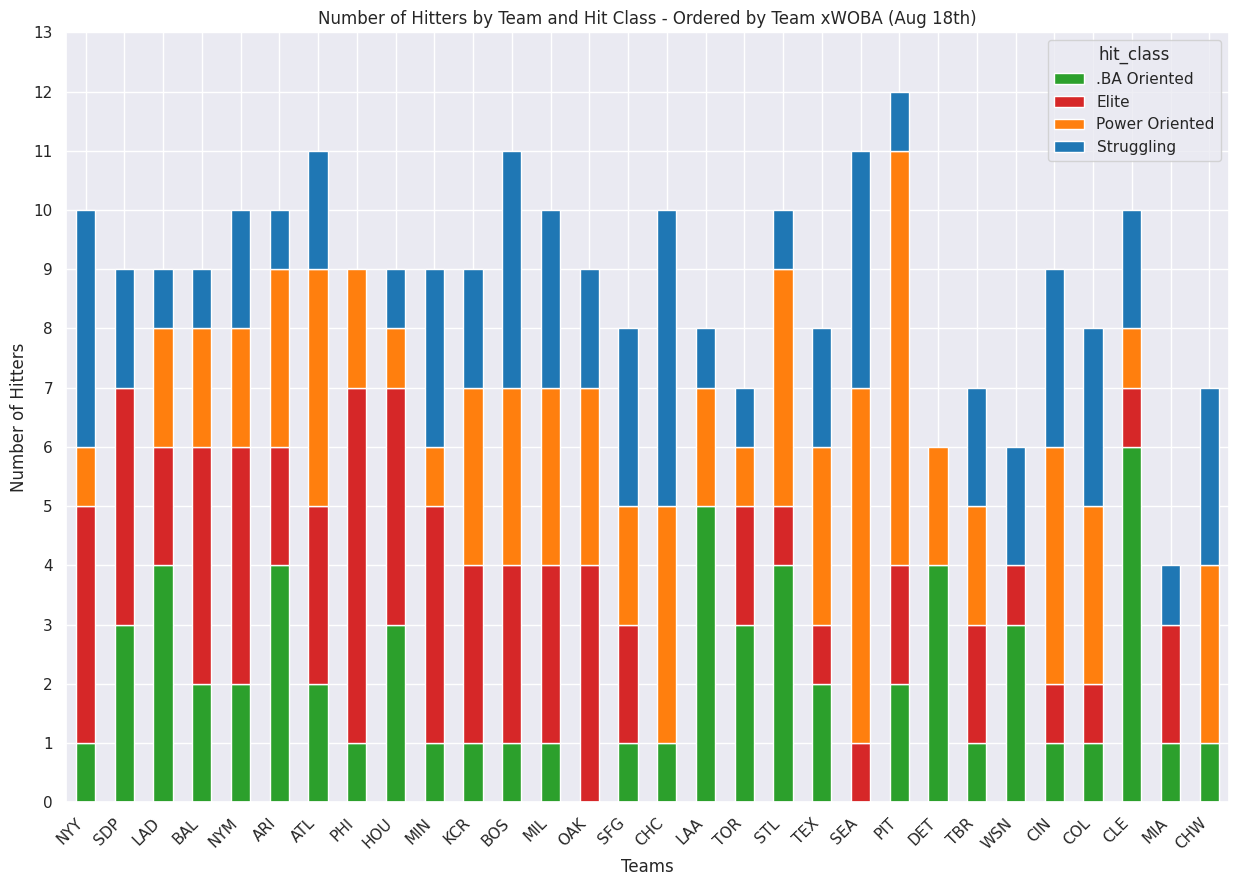

In [653]:
# Group the data by 'Team' and 'hit_class'
Teams_Grouped = grouped.groupby(['Team', 'hit_class']).size().unstack()

# Define the color map 
color_map = {'Struggling': 'tab:blue', 'Elite': 'tab:red', 'Power Oriented': 'tab:orange', '.BA Oriented': 'tab:green'}

# Get the colors for the bars
colors = [color_map[col] for col in Teams_Grouped.columns]

# Define custom order (xWOBA Team Standings of August 18th)
custom_order = ['NYY', 'SDP', 'LAD', 'BAL', 'NYM', 'ARI', 'ATL', 'PHI', 'HOU', 'MIN', 'KCR', 'BOS', 'MIL', 'OAK', 'SFG', 'CHC', 'LAA', 'TOR', 'STL', 'TEX', 'SEA', 'PIT', 'DET', 'TBR', 'WSN', 'CIN', 'COL', 'CLE', 'MIA', 'CHW']

# Reindex the dataframe with the custom order
sorted_grouped = Teams_Grouped.reindex(custom_order)


# Create the stacked bar chart
sorted_grouped.plot(kind='bar', stacked=True, figsize=(15, 10), color=colors)
# Add title and labels
plt.title('Number of Hitters by Team and Hit Class - Ordered by Team xWOBA (Aug 18th)')
plt.xlabel('Teams')
plt.ylabel('Number of Hitters')
# Set y-axis intervals to 1.0
y_min, y_max = plt.ylim()
plt.yticks(np.arange(y_min, y_max + 1, 1))  # Adjust interval to 1.0

# Rotate the x-axis labels 
plt.xticks(rotation=45, ha='right')


plt.show()

To get a more interpretable view, I created the following tables. The tables are also **ordered by team xWOBA (as of August 18th)**:

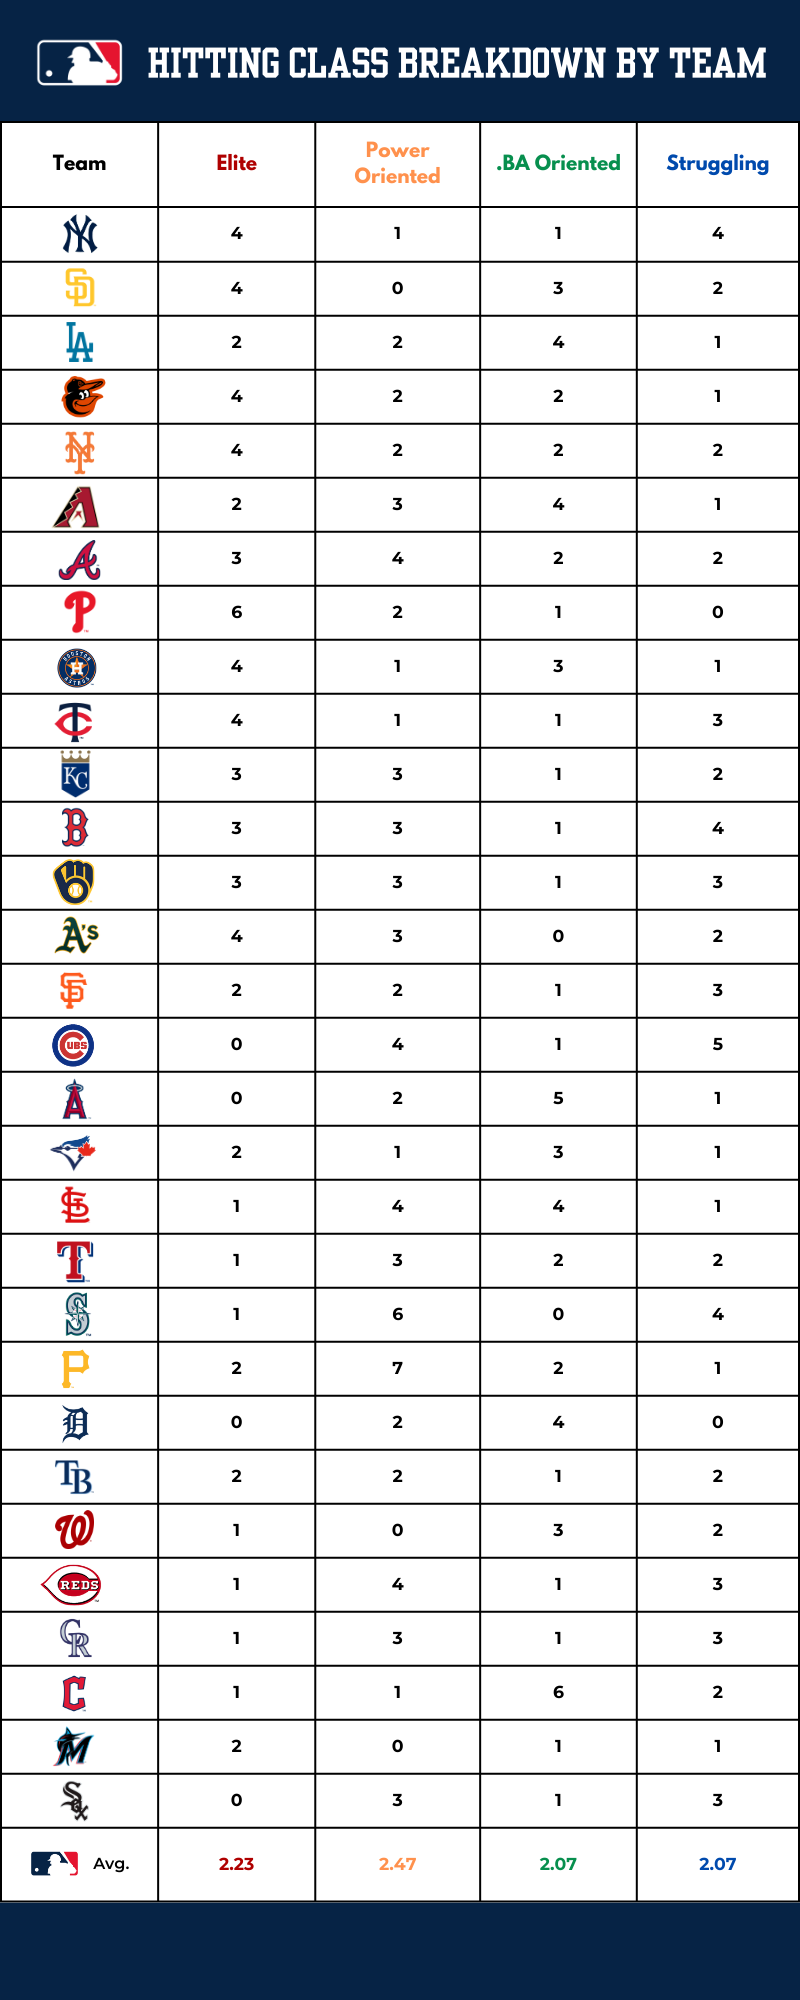 

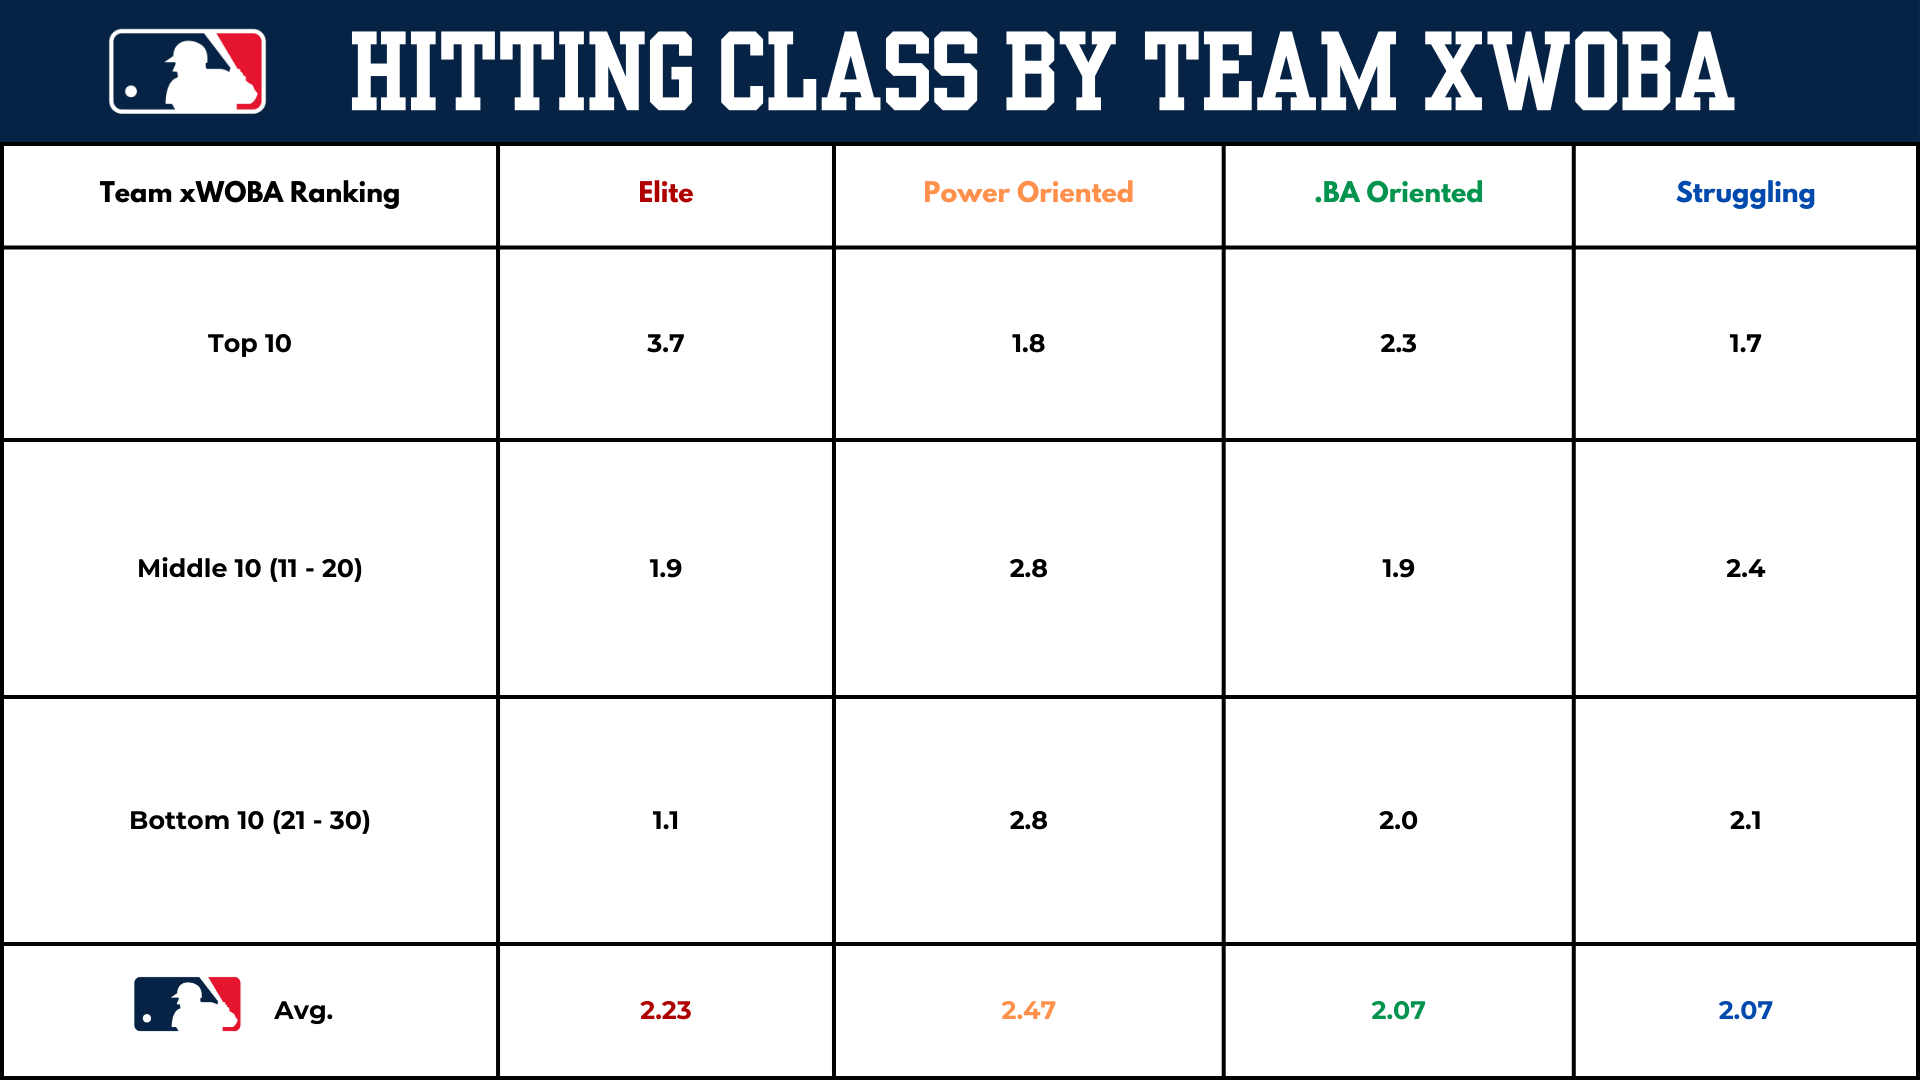

**ANALYSIS & IMPLICATIONS:**

**1) 'Elite' hitters are an absolute need.** Within the top 10 teams in xWOBA, the average of Elite hitters is 3.7 compared to below 2.0 for the rest of the 20 teams. This demonstrates how critical 'Elite' hitters are for offensive production, being a key determinant in a team's overall offensive production. Specifically, it seems the ideal number of 'Elite' hitters is **4**. 7 of the top 10 teams have 4 'Elite' hitters or more, demonstrating the significance of meeting this threshold. The Athletics are the only team with 4 'Elite' hitters and are not in the top 10, but this is mainly due to the balance of their lineup (this idea will be discussed in the next few bullet points). 

Certain teams within the top 10 have been able to undercut this threshold (Los Angeles Dodgers, Arizona Diamondbacks, Atlanta Braves), but you'll notice that their quite unique. The Los Angeles Dodgers and Atlanta Braves have both been experiencing injuries to their key stars, namely Mookie Betts for LAD and Ronald Acuna Jr. for ATL. Thus, they still have 3-4 'Elite' hitters in their arsenal. Even despite this, each team has gotten by having more 'specialized' hitters (e.g., 'power oriented' and '.BA oriented) (I'll expand on this idea within the next few bullet points). This leaves the Arizona Diamondbacks as a true exception to this 'rule of 4'. The compensate for their lower number of 'Elite' hitters, the Diamondbacks add extra 'Power Oirented' and '.BA Oriented' hitters. As I'll explain within the next few bullet points, the Diamondbacks balance these two classifications evenly which allows them to experience greater results (semmingly). Combined with their mitigation of 'Struggling' hitters (just 1 recorded), the lineup is still able to be top 10 in xWOBA. 

**2) Balance is needed. Overreliance on one hitting class will only lead to poor results.** Observing the top 10 teams, there is a clear distribution between the classes. 9 of the 10 teams have players in both the 'Power Oriented' Classes the '.BA Oriented' class, with msot of these teams spliting them quite evenly. Intuitively, it makes sense to balance these two classes as they perfectly compliment one another. '.BA Oriented' batters would set the table for 'Power Oriented' hitters to drive them in, creating for the most effecient offenses possible. With the numbers now visible to us, this assumption becomes stronger. Observing the data, it seems that a **2 of each category** (.BA Oriented, Power Oriented) seems like a perfect balance (assuming you are close to or have met the 4 'Elite' player target), but a **3-2/2-3 split in either direction is also favourable**. 

The notable exceptions to this concept is the San Diego Padres, ranked 2nd in Team xWOBA. This exception mainly occurs due 2 main factors: 
1. SDP's 'Elite' hitters are among the best in the league. This includes Manny Machado, Fernando Tatis Jr, and Jurickson Profar, with the last 2 being among the top 25 players in xWOBA. Fernando Tatis especially covers this need for power hitting, being among the top 25 players in xISO. Thus, they're able to compensate for more of the imbalence in San Diego's offense initially caused by the lack of 'Power Oriented' hitters (effectively, there is no deficiency in power hitting).
2. SDP's 'Struggling' hitters (Ha-Seong Kim, Luis Campusano) aren't performing too poorly. Analyzing both of these hitters further, it becomes clear that their expertise is getting on base even with lower xBA averages. In particular, Ha-seong Him Ranks in the 93rd percentile in BB%, implicating his ability to get on base to create more run creation opportunities. Admittedly, my analysis neglects a offensive capability outside of swining a bat, so it's important I can acknowledge these areas when possible. As for Luis Campusano, he isn't too great at getting on base by hitting or walking either. However, he is in the 93rd percentile for K%, potentially indicating that his outs are more productive than most players (either maintaining the run-creation opportunities for other players, or even progressing it). 

The charts below demonstrate the findings I just discussed.

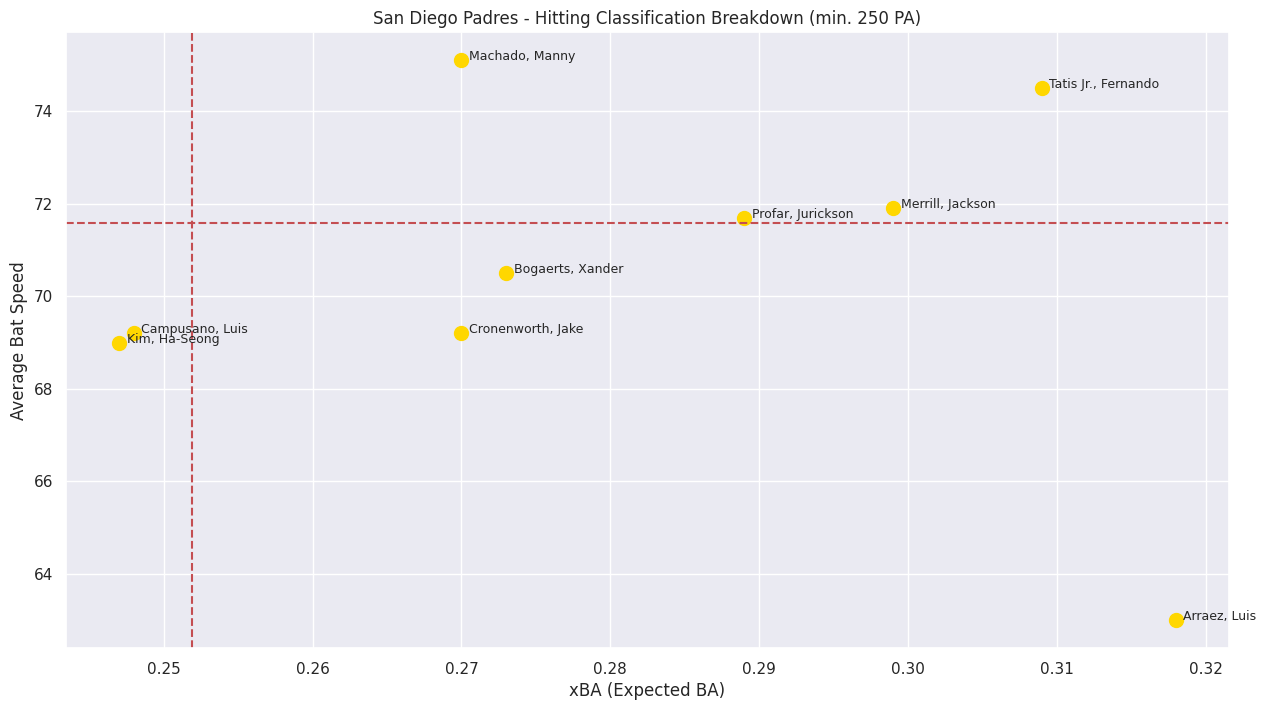

In [654]:
# Create dataset for Padres Players
SDP = grouped[grouped['Team'] == "SDP"]

# Create the scatter plot
plt.figure(figsize=(15, 8))
plt.scatter(SDP['xba'], SDP['avg_swing_speed'], color='gold', s=100)
plt.xlabel('xBA (Expected BA)')
plt.ylabel('Average Bat Speed')
plt.title('San Diego Padres - Hitting Classification Breakdown (min. 250 PA)')
plt.grid(True)

# Plot averages
plt.axhline(y=np.mean(grouped['avg_swing_speed']), color='r', linestyle='--')
plt.axvline(x=np.mean(grouped['xba']), color='r', linestyle='--')


# Plot the name
for i, row in SDP.iterrows():
    plt.text(row['xba'] + 0.0005, row['avg_swing_speed'], 
             row['last_name, first_name'], fontsize=9, ha='left')


Outside of the top 10 teams in xWOBA, we can note a lot of teams that are too heavily focused on one hitting category. Obvious examples include the Oakland Athletics (3 'power oriented' and 0 '.ba oriented'), Seattle Mariners (6 'power oriented' and 0 '.ba oriented'), Cleveland Guardians (6 '.ba oriented' and 1 'power oriented), and the Pittsburgh Pirates (7 'power oriented' and 2 '.ba oriented'). For the power-heavy offenses, they likely struggle from the lack of runners on bases which would set-up their power hitters. As they're already crippled by the lack of 'Elite' hitters, it makes it difficult for these offenses to get anything generated with the lower xBAs of these 'power oriented' hitters. On the other hand, offenses dominated by '.ba oriented' hitters will likely struggle due to the lack of power in their offense. While players are able to get on base more often, the lack of power hitters to drive them in hurts their overall efficiency. Essentially, all offenses require some sort of balance between '.ba oriented' and 'power oriented' hitting (either through these specializes hitters, or through higher quality 'Elite' hitters) in some shape or form. 

To confirm all of these insights, I will further examine this idea as I analyze lineup construction across the MLB. 

**3) 'Struggling' hitters can be overcome, but not without a great amount of effort.**

Without a doubt, 'Struggling' hitters can significantly deter from a team's offensive performance. As we've previously established in our analysis, these hitters tend to rank lowest in all of the critical offensive metrics, includign xBA, xWOBA, and xISO. Understanding this, its easy to note how the top 10 teams effectively mitigated these 'struggling' hitters, resulting in better overall production. The rest of these teams (11th - 20th especially) seemed to struggle with this, hindering their offenses even despite the presence of 'Elite' hitters.

The main exception to this insight is the New York Yankees, being ranked as the top offense even despite having 4 'Struggling' hitters. Upon further examination, it becomes quite clear as to why this occured:
1. Their 'Elite' hitters are among the best in the league. In particular, Aaron Judge and Juan Soto are the top 2 players in xWOBA and xISO. Given the offensive production of these 2 players alone, it makes sense that the defencies caused by 'Struggling' hitters are made up for. For what its worth, Giancarlo Stanton (44th in xWOBA) and Austin Wells (42nd xWOBA) are among the top 50 players in terms of xWOBA. As the Yankees have such high-class players within their lineup, it makes sense for them to be atop the rankings despite the number of 'Struggling' hitters.
2. Their 'Struggling' hitters aren't performing too bad. As evidenced by the scatter plot below, all of their 'Struggling' hitters are within ~4mph of the bat speed average, and ~0.015 of the xBA average. As such, their performance isn't as much of a deterrance as other 'Struggling' players. Once again, I recognize that this is a weakness in my classification system. Thus, its important that I continue to acknowledge these flaws and contextualize it when necessary.

While the Yankees were able to mitigate the below-average performance of their 'Struggling' hitters, it's important to recognize how much of an anomaly this is. If it hadn't been for there extremely well performing 'Elite' players, their offense would've been almost certainly below the top 10. As such, teams should focus on mitigating the number of 'Struggling' hitters they have (either through player acquisition, lineup control, player development, etc.) rather than actively attempting to counteracting. I recognize that 'Struggling' hitters are inevitable, which is why my suggestion is based around "mitigating" the number rather than eliminating it entirely. As we'll see in the next section, lineup control will play a critical role in this. 

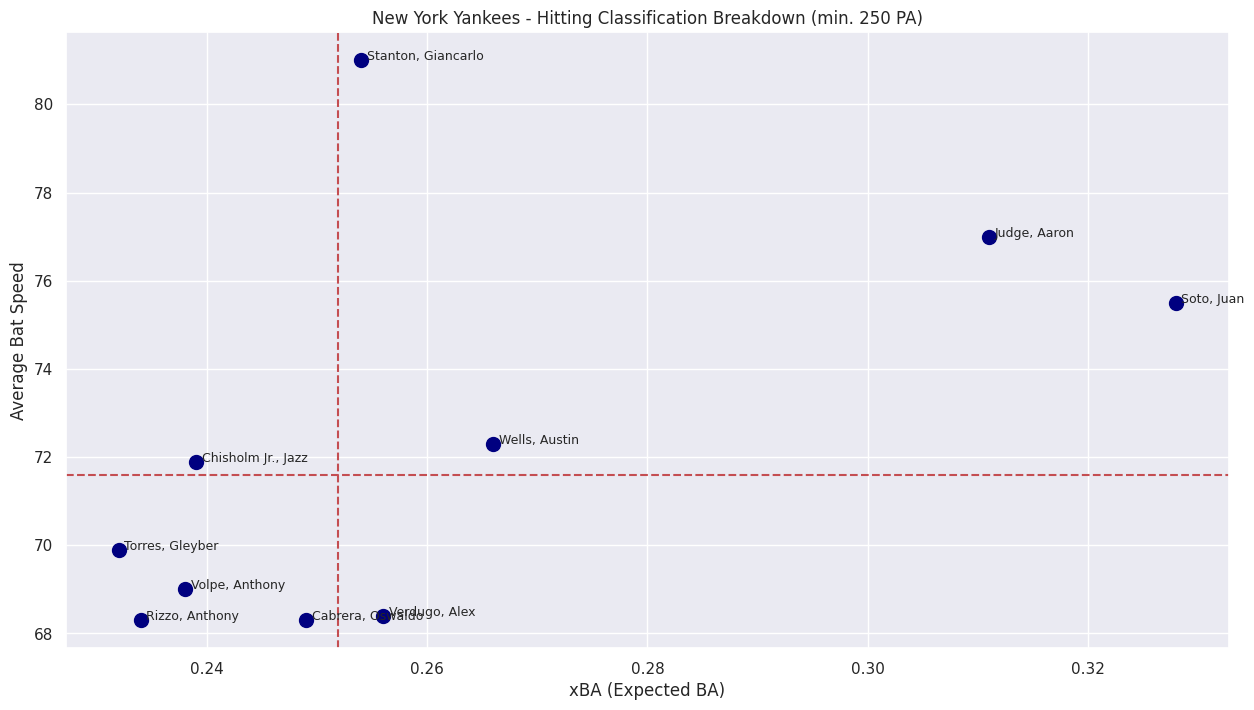

In [655]:
# Create dataset for Padres Players
NYY = grouped[grouped['Team'] == "NYY"]

# Create the scatter plot
plt.figure(figsize=(15, 8))
plt.scatter(NYY['xba'], NYY['avg_swing_speed'], color='navy', s=100)
plt.xlabel('xBA (Expected BA)')
plt.ylabel('Average Bat Speed')
plt.title('New York Yankees - Hitting Classification Breakdown (min. 250 PA)')
plt.grid(True)

# Plot averages
plt.axhline(y=np.mean(grouped['avg_swing_speed']), color='r', linestyle='--')
plt.axvline(x=np.mean(grouped['xba']), color='r', linestyle='--')


# Plot the name
for i, row in NYY.iterrows():
    plt.text(row['xba'] + 0.0005, row['avg_swing_speed'], 
             row['last_name, first_name'], fontsize=9, ha='left')


## **Lineup Construction:** How have teams constructed their lineups? Are there any trends to note?

While the roster construction based analysis provided us with plenty of valuable insights, its important we expand on and validate these ideas through more in-depth analysis. More specifically, we need to analyze **how teams are constructing their lineups**. 

**IMPORTANT NOTE:** For purposes of this analysis, I will be extracting lineup roles from FanGraphs. Whatever FanGraphs has listed as their 'Role' is what I'll use for their assumed lineup position. I recognize that these players have likely varied in their role throughout the season, so I'll take this into account as I evaluate each lineup.

In [656]:
# Load all sheets from the Excel file
df = pd.read_excel('/kaggle/input/lineups24/Lineups.xlsx', sheet_name=None)

# Combine all sheets into a single DataFrame
Lineups = pd.concat(df.values(), ignore_index=True)

Lineups.head()

,Name,Role,Ovr,Last 7 Days,Tue 8/20 vs. L,Mon 8/19 vs. R,Sun 8/18 vs. R,Sat 8/17 vs. L,Fri 8/16 vs. R,Wed 8/14 vs. R,...,Tue 5/28 vs. R.1,Thu 4/4 vs. R.1,Tue 5/14 vs. R.1,Mon 7/29 vs. R.1,Sat 6/22 vs. L,Thu 5/23 vs. L,Thu 5/16 vs. L,Thu 5/9 vs. L,Wed 4/17 vs. R.1,Wed 5/29 vs. R.1
0,Taylor Ward,1,95.0,292.0,LF (1),LF (1),LF (1),LF (1),LF (1),LF (5),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Zach Neto,2,52.0,237.0,SS (2),SS (2),SS (2),SS (2),SS (2),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Nolan Schanuel,3,97.0,118.0,1B (3),1B (3),1B (3),1B (3),1B (3),1B (1),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Niko Kavadas,4,1352.0,402.0,NaN,DH (4),DH (4),NaN,DH (4),AAA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Anthony Rendon,5,371.0,359.0,3B (6),3B (5),INJ,INJ,3B (6),3B (2),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### **Data Cleaning** - Lineups Data (Sourced from FanGraphs)

Due to the way FanGraphs formats their data, some data cleaning is needed:

In [657]:
# Function to add 'last_name, first_name' column to our lineup data
def reverse_format_name(formatted_name):
    # Split the formatted name by ', '
    last_name, first_name = formatted_name.split(', ', 1)
    # Combine into the desired format: 'first_name last_name'
    return f"{first_name} {last_name}"

# Apply the function to the 'last_name, first_name' column
grouped['Name'] = grouped['last_name, first_name'].apply(reverse_format_name)

# Remove any names from 'Lineups' dataset that aren't in the grouped one
lineups_mod = Lineups.merge(grouped[['Name']], how='inner', on='Name')

# Check number of names
lineups_mod['Name'].nunique()

260

There are 5 players missing from our dataset. Let's investigate this further:

In [658]:
# Find names in grouped that are not in Lineups_mod
excluded_names = grouped[~grouped['Name'].isin(lineups_mod['Name'])]

# Print excluded names
excluded_names

,"last_name, first_name",player_id,year,pa,home_run,k_percent,bb_percent,xba,xslg,xwoba,...,swing_percent,pull_percent,straightaway_percent,opposite_percent,groundballs_percent,flyballs_percent,linedrives_percent,hit_class,Team,Name
16,"Springer III, George",543807,2024,469,14,19.2,10.2,0.256,0.418,0.330,...,49.9,37.2,40.5,22.3,50.0,21.6,22.6,Elite,TOR,George Springer III
111,"Mullins II, Cedric",656775,2024,370,13,21.1,6.8,0.216,0.348,0.274,...,53.0,40.0,33.5,26.5,32.7,28.8,23.8,Struggling,BAL,Cedric Mullins II
170,"Rooker Jr., Brent",667670,2024,436,29,29.6,9.9,0.280,0.608,0.403,...,48.8,43.5,36.2,20.4,31.5,34.6,24.6,Elite,OAK,Brent Rooker Jr.
179,"Melendez Jr., MJ",669004,2024,342,14,24.6,7.0,0.245,0.434,0.318,...,53.0,45.0,33.3,21.6,41.1,29.0,20.8,Power Oriented,KCR,MJ Melendez Jr.
199,"García, Luis",671277,2024,412,14,15.8,5.1,0.293,0.475,0.344,...,51.1,24.2,46.3,29.4,46.6,25.5,24.8,.BA Oriented,WSN,Luis García


Upon further investigation, these errors occured due to differences in how FanGraphs and Baseball Savant stores players' names. As such, I'll make the following adjustments and re-merge the datasets

In [659]:
# Manually adjust specific rows (focusing on adjusting 'Name' column as we'll merge by this column)
grouped.loc[grouped['Name'] == 'George Springer III', 'Name'] = 'George Springer'
grouped.loc[grouped['Name'] == 'Cedric Mullins II', 'Name'] = 'Cedric Mullins'
grouped.loc[grouped['Name'] == 'Brent Rooker Jr.', 'Name'] = 'Brent Rooker'
grouped.loc[grouped['Name'] == 'MJ Melendez Jr.', 'Name'] = 'MJ Melendez'
grouped.loc[grouped['player_id'] == 671277, 'Name'] = 'Luis Garcia'
Lineups.loc[Lineups['playerId'] == 20391, 'Name'] = 'Luis Garcia' # Luis Garcia's name is giving issue due to the accent on the letter i. Thus, we'll adjust his name in both the 'Lineups' and 'grouped' datasets

# Remove any names from 'Lineups' dataset that aren't in the grouped one
lineups_mod = Lineups.merge(grouped[['Name']], how='inner', on='Name')

# Check number of names
lineups_mod['Name'].nunique()

265

With this sorted, I'll now focus on assigning a role to every single player:

In [660]:
# Check for any values that aren't a listed lineup role (e.g., 1 - 9)
no_role = lineups_mod[
    (lineups_mod['Role'] != "1") &
    (lineups_mod['Role'] != "2") &
    (lineups_mod['Role'] != "3") &
    (lineups_mod['Role'] != "4") &
    (lineups_mod['Role'] != "5") &
    (lineups_mod['Role'] != "6") &
    (lineups_mod['Role'] != "7") &
    (lineups_mod['Role'] != "8") &
    (lineups_mod['Role'] != "9")
]

no_role

,Name,Role,Ovr,Last 7 Days,Tue 8/20 vs. L,Mon 8/19 vs. R,Sun 8/18 vs. R,Sat 8/17 vs. L,Fri 8/16 vs. R,Wed 8/14 vs. R,...,Tue 5/28 vs. R.1,Thu 4/4 vs. R.1,Tue 5/14 vs. R.1,Mon 7/29 vs. R.1,Sat 6/22 vs. L,Thu 5/23 vs. L,Thu 5/16 vs. L,Thu 5/9 vs. L,Wed 4/17 vs. R.1,Wed 5/29 vs. R.1
6,Luis Rengifo,IL,169.0,NaN,IL,IL,IL,IL,IL,IL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Willie Calhoun,AAA,250.0,226.0,AAA,AAA,AAA,AAA,DFA,DH (4),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,Kyle Tucker,IL,115.0,NaN,NaN,IL,NaN,NaN,NaN,IL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,Abraham Toro,Bench,203.0,269.0,NaN,3B (7),NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,Davis Schneider,Bench,198.0,405.0,NaN,NaN,NaN,LF (7),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,Paul DeJong,KCR,143.0,36.0,KCR,NaN,NaN,NaN,KCR,KCR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SS (6),NaN
276,Eloy Jiménez,BAL,263.0,313.0,BAL,NaN,NaN,NaN,BAL,BAL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DH (4),NaN
277,Tommy Pham,STL,180.0,338.0,STL,NaN,NaN,NaN,STL,STL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAA,NaN
286,Jazz Chisholm Jr.,IL,43.0,NaN,IL,NaN,NaN,NaN,IL,IL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There are 91 players who have potential issues with their lineup entries. As such, I decided to extract the files and take a closer look at these players.

These players fell into 3 different categories, in which I would apply a different solution to apply their most accurate lineup position

1. Bench Players --> Apply the lineup position they most frequented (consider for recent trends in lineup position)
2. Injured Players --> Apply the lineup position they most frequented (pre-injury) (consider for recent trends in lineup position)
3. Players Who Switched Team --> Apply the lineup position most frequented while they were on this new team

As such, I made the following ammendments to these players:

In [661]:
import pandas as pd

# Define the data (the 91 values which needs to be re-adjusted)
data = {
    "Name": [
        "Luis Rengifo", "Willie Calhoun", "Kyle Tucker", "Abraham Toro", "Davis Schneider",
        "Bo Bichette", "Isiah Kiner-Falefa", "Justin Turner", "Danny Jansen", "Travis d'Arnaud",
        "Adam Duvall", "Ozzie Albies", "Austin Riley", "Eddie Rosario", "Jake Bauers",
        "Christian Yelich", "Blake Perkins", "Tommy Pham", "Michael Siani", "Mike Tauchman",
        "Christopher Morel", "Christian Walker", "Gabriel Moreno", "Ketel Marte", "Enrique Hernández",
        "Andy Pages", "Amed Rosario", "Mark Canha", "Patrick Bailey", "Jorge Soler",
        "David Fry", "Tyler Freeman", "Justin Turner", "Mitch Garver", "Dylan Moore",
        "J.P. Crawford", "Ty France", "Nick Gordon", "Jazz Chisholm Jr.", "Luis Arraez", "Bryan De La Cruz",
        "Josh Bell", "Jesse Winker", "Harrison Bader", "Ildemaro Vargas", "Joey Meneses",
        "Eddie Rosario", "Jesse Winker", "Lane Thomas", "Nick Senzel", "Eloy Jiménez",
        "Jordan Westburg", "Luis Campusano", "Fernando Tatis Jr.", "Ha-Seong Kim", "Michael A. Taylor",
        "Connor Joe", "Nick Gonzales", "Andrew McCutchen", "Ke'Bryan Hayes", "Jack Suwinski",
        "Jonah Heim", "José Caballero", "Ben Rortvedt", "Richie Palacios", "Amed Rosario",
        "Isaac Paredes", "Randy Arozarena", "Rob Refsnyder", "Danny Jansen", "Dominic Smith",
        "Amed Rosario", "Will Benson", "Jeimer Candelario", "Elias Díaz", "Maikel Garcia",
        "Hunter Renfroe", "Javier Báez", "Wenceel Pérez", "Gio Urshela", "Mark Canha",
        "Jose Miranda", "Manuel Margot", "Carlos Correa", "Byron Buxton", "Nick Senzel",
        "Paul DeJong", "Eloy Jiménez", "Tommy Pham", "Jazz Chisholm Jr.", "Anthony Rizzo"
    ],
    "Role": [
        2, 4, 2, 6, 7, 4, 1, 7, 7, 6, 6, 2, 3, 9, 5, 3, 9, 7, 9, 4, 3, 4, 6, 2, 8, 5, 7, 7, 5, 1,
        5, 7, 7, 5, 9, 1, 7, 6, 6, 1, 5, 4, 6, 9, 8, 4, 9, 6, 5, 6, 5, 5, 8, 2, 8, 9, 3, 5, 1, 6,
        8, 8, 7, 8, 6, 9, 5, 2, 3, 7, 8, 9, 9, 6, 4, 1, 5, 8, 1, 7, 7, 4, 1, 2, 5, 6, 7, 5, 7, 6, 6
    ],
    "playerId": [
        19858, 17838, 18345, 19844, 23565, 19612, 16512, 5235, 16535, 7739, 10950, 16556, 18360, 12155, 15194,
        11477, 19921, 2967, 22557, 15274, 21897, 13419, 22664, 13613, 10472, 24816, 15518, 11445, 27478, 14221,
        24934, 22532, 5235, 15161, 18042, 15491, 17982, 16337, 20454, 18568, 19600, 13145, 13590, 18030, 13324,
        14366, 12155, 13590, 16939, 19293, 17484, 27815, 22217, 19709, 27506, 11489, 16572, 27490, 9847, 18577,
        22244, 16930, 23401, 20287, 24589, 15518, 20036, 19290, 13770, 16535, 15653, 15518, 21853, 13621, 11680,
        22715, 15464, 12979, 22857, 10681, 11445, 20538, 14712, 14162, 14161, 19293, 18015, 17484, 2967, 20454, 3473
    ]
}

# Create a DataFrame for the updates
UpdateRoles = pd.DataFrame(data)

# Convert 'Role' in UpdateRoles to strings
UpdateRoles['Role'] = UpdateRoles['Role'].astype(str)

Let's now apply these updates to our own dataset:

In [662]:
# Function to apply updated roles
for i in range(len(UpdateRoles)):
    # Find the index of the playerId in lineups_mod
    index = lineups_mod[lineups_mod['Name'] == UpdateRoles.iloc[i]['Name']].index
    
    # Update the 'Role' column in lineups_mod for that index
    lineups_mod.iloc[index, lineups_mod.columns.get_loc('Role')] = UpdateRoles.iloc[i]['Role']
    
# Do individual iloc for Elias Diaz as his there was difficulty in updating his info
lineups_mod.loc[lineups_mod['playerId'] == 11680, 'Role'] = '4'

In [663]:
# Confirm that all roles are assigned
no_role = lineups_mod[
    (lineups_mod['Role'] != "1") &
    (lineups_mod['Role'] != "2") &
    (lineups_mod['Role'] != "3") &
    (lineups_mod['Role'] != "4") &
    (lineups_mod['Role'] != "5") &
    (lineups_mod['Role'] != "6") &
    (lineups_mod['Role'] != "7") &
    (lineups_mod['Role'] != "8") &
    (lineups_mod['Role'] != "9")
]

no_role

,Name,Role,Ovr,Last 7 Days,Tue 8/20 vs. L,Mon 8/19 vs. R,Sun 8/18 vs. R,Sat 8/17 vs. L,Fri 8/16 vs. R,Wed 8/14 vs. R,...,Tue 5/28 vs. R.1,Thu 4/4 vs. R.1,Tue 5/14 vs. R.1,Mon 7/29 vs. R.1,Sat 6/22 vs. L,Thu 5/23 vs. L,Thu 5/16 vs. L,Thu 5/9 vs. L,Wed 4/17 vs. R.1,Wed 5/29 vs. R.1


Now that we've successfully added roles for every player, we can focus on removing any duplicate rows.

In [664]:
# Retrieve duplicated rows
duplicate_rows = lineups_mod[lineups_mod['Name'].duplicated()]

# Get indices of the duplicated rows
duplicate_indices = duplicate_rows.index

# Drop rows with duplicated indices from `lineups_mod`
lineups_finished = lineups_mod.drop(index=duplicate_indices)

lineups_finished.head()

,Name,Role,Ovr,Last 7 Days,Tue 8/20 vs. L,Mon 8/19 vs. R,Sun 8/18 vs. R,Sat 8/17 vs. L,Fri 8/16 vs. R,Wed 8/14 vs. R,...,Tue 5/28 vs. R.1,Thu 4/4 vs. R.1,Tue 5/14 vs. R.1,Mon 7/29 vs. R.1,Sat 6/22 vs. L,Thu 5/23 vs. L,Thu 5/16 vs. L,Thu 5/9 vs. L,Wed 4/17 vs. R.1,Wed 5/29 vs. R.1
0,Taylor Ward,1,95.0,292.0,LF (1),LF (1),LF (1),LF (1),LF (1),LF (5),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Zach Neto,2,52.0,237.0,SS (2),SS (2),SS (2),SS (2),SS (2),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Nolan Schanuel,3,97.0,118.0,1B (3),1B (3),1B (3),1B (3),1B (3),1B (1),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Logan O'Hoppe,6,134.0,291.0,C (5),C (6),NaN,C (5),C (5),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Mickey Moniak,8,227.0,351.0,NaN,CF (8),CF (8),NaN,RF (7),CF (6),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


With everything accounted for, we can finally add the lineup data to the 'grouped' dataset

In [665]:
# Add Lineup Role to 'grouped' dataset
grouped = grouped.merge(lineups_finished[['Name', 'Role']], on='Name', how='left')

grouped.head()

,"last_name, first_name",player_id,year,pa,home_run,k_percent,bb_percent,xba,xslg,xwoba,...,pull_percent,straightaway_percent,opposite_percent,groundballs_percent,flyballs_percent,linedrives_percent,hit_class,Team,Name,Role
0,"Blackmon, Charlie",453568,2024,372,8,16.9,8.3,0.246,0.361,0.301,...,44.0,35.2,20.9,38.8,25.3,23.8,Struggling,COL,Charlie Blackmon,1
1,"McCutchen, Andrew",457705,2024,437,16,26.1,11.7,0.237,0.443,0.340,...,38.1,41.9,20.0,41.9,27.2,21.9,Power Oriented,PIT,Andrew McCutchen,1
2,"Turner, Justin",457759,2024,395,7,18.5,10.6,0.248,0.373,0.324,...,40.4,34.8,24.8,34.8,29.3,28.5,Struggling,SEA,Justin Turner,7
3,"Santana, Carlos",467793,2024,446,17,17.3,10.3,0.245,0.419,0.327,...,48.9,32.8,18.3,37.9,29.3,22.7,Struggling,MIN,Carlos Santana,5
4,"Pham, Tommy",502054,2024,350,7,20.6,8.6,0.282,0.433,0.341,...,35.4,37.0,27.6,43.1,20.7,30.5,Elite,STL,Tommy Pham,7


### **Lineup Construction Analysis:** Deriving Insights

To derrive some insights, I created a subplot matrix with all of the teams and their lineup breakdown by hitting class. 

**IMPORTANT NOTES:** 
* Beside each team I provided their record **as of August 21st, 2024**.
* If a team didn't have values for all 9 lineup slots, its likely because **they didn't have enough players that met the minimum 250 PA** threshold for those lineup slots

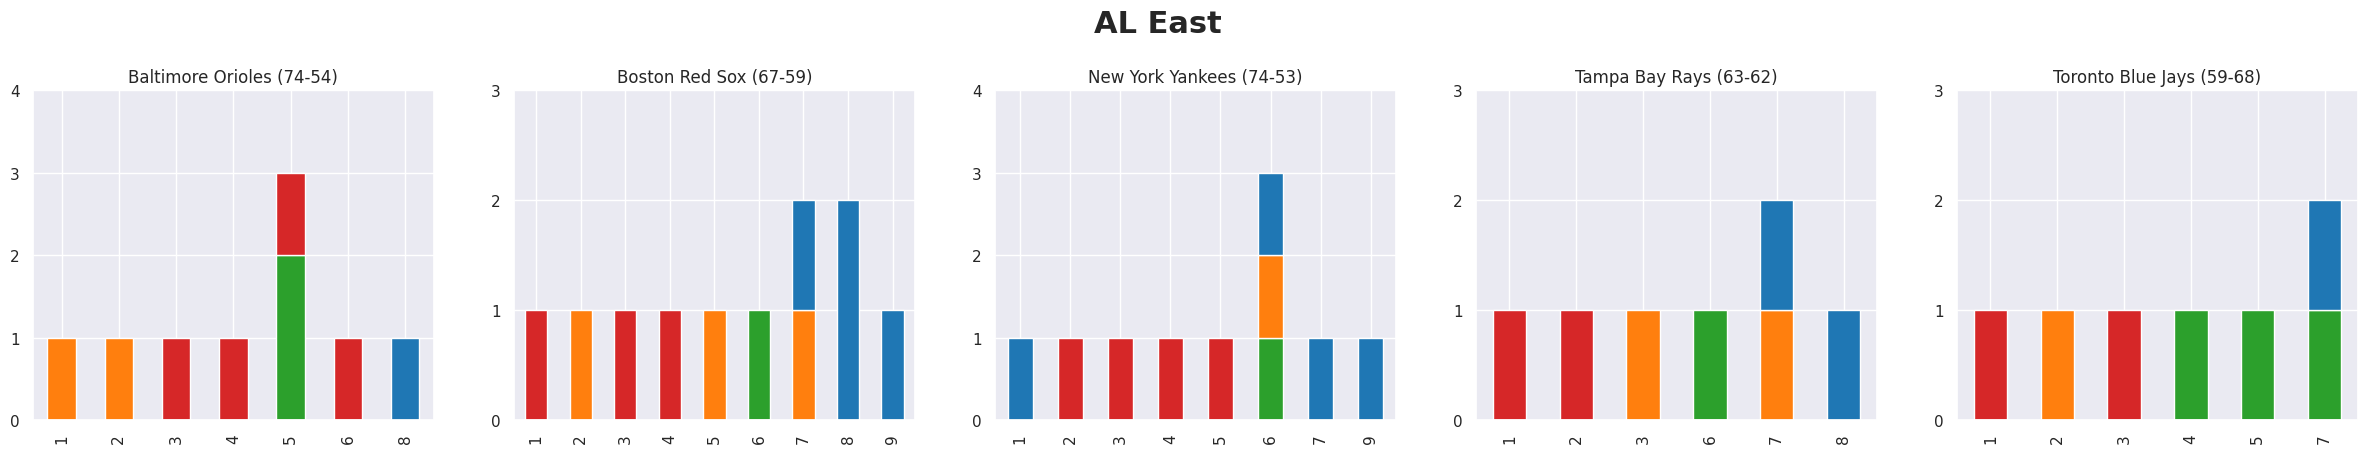

In [666]:
# Define the color map 
color_map = {'Struggling': 'tab:blue', 'Elite': 'tab:red', 'Power Oriented': 'tab:orange', '.BA Oriented': 'tab:green'}

# Get the colors for the bars
colors = [color_map[col] for col in Teams_Grouped.columns]


# Create a subplot matrix with plots for the 5 divisional teams

# Create the frame for subplots
fig, ax = plt.subplots(figsize = (15,15))

# Add Axes and Individual Grids - Subplot Grids
ax1 = plt.subplot2grid(shape=(6,5), loc=(0,0))
ax2 = plt.subplot2grid(shape=(6,5), loc=(0,1))
ax3 = plt.subplot2grid(shape=(6,5), loc=(0,2))
ax4 = plt.subplot2grid(shape=(6,5), loc=(0,3))
ax5 = plt.subplot2grid(shape=(6,5), loc=(0,4))

# Baltimore Orioles
BAL = grouped[grouped['Team'] == "BAL"]
BALplot = BAL.groupby(['Role', 'hit_class']).size().unstack()
# Create the stacked bar chart
BALplot.plot(kind='bar', stacked=True, figsize=(30, 30), color=colors, ax=ax1, title = 'Baltimore Orioles (74-54)', xlabel = '')
ax1.legend().remove()
# Set y-axis intervals to 1.0
y_min, y_max = ax1.get_ylim()
ax1.set_yticks(np.arange(y_min, y_max + 1, 1))  # Adjust interval to 1.0

# Boston Red Sox
BOS = grouped[grouped['Team'] == "BOS"]
BOSplot = BOS.groupby(['Role', 'hit_class']).size().unstack()
# Create the stacked bar chart
BOSplot.plot(kind='bar', stacked=True, figsize=(30, 30), color=colors, ax=ax2, title = 'Boston Red Sox (67-59)', xlabel = '')
ax2.legend().remove()
# Set y-axis intervals to 1.0
y_min, y_max = ax2.get_ylim()
ax2.set_yticks(np.arange(y_min, y_max + 1, 1))  # Adjust interval to 1.0

# New York Yankees
NYY = grouped[grouped['Team'] == "NYY"]
NYYplot = NYY.groupby(['Role', 'hit_class']).size().unstack()
# Create the stacked bar chart
NYYplot.plot(kind='bar', stacked=True, figsize=(30, 30), color=colors, ax=ax3, title = 'New York Yankees (74-53)', xlabel = '')
ax3.legend().remove()
# Set y-axis intervals to 1.0
y_min, y_max = ax3.get_ylim()
ax3.set_yticks(np.arange(y_min, y_max + 1, 1))  # Adjust interval to 1.0

# Tampa Bay Rays
TBR = grouped[grouped['Team'] == "TBR"]
TBRplot = TBR.groupby(['Role', 'hit_class']).size().unstack()
# Create the stacked bar chart
TBRplot.plot(kind='bar', stacked=True, figsize=(30, 30), color=colors, ax=ax4, title = 'Tampa Bay Rays (63-62)', xlabel = '')
ax4.legend().remove()
# Set y-axis intervals to 1.0
y_min, y_max = ax4.get_ylim()
ax4.set_yticks(np.arange(y_min, y_max + 1, 1))  # Adjust interval to 1.0

# Toronto Blue Jays
TOR = grouped[grouped['Team'] == "TOR"]
TORplot = TOR.groupby(['Role', 'hit_class']).size().unstack()
# Create the stacked bar chart
TORplot.plot(kind='bar', stacked=True, figsize=(30, 30), color=colors, ax=ax5, title = 'Toronto Blue Jays (59-68)', xlabel = '')
ax5.legend().remove()
# Set y-axis intervals to 1.0
y_min, y_max = ax5.get_ylim()
ax5.set_yticks(np.arange(y_min, y_max + 1, 1))  # Adjust interval to 1.0

# Built a title for the entire subplot grid
fig.suptitle('AL East', fontsize=22, weight='bold', y = 0.907)

plt.show()

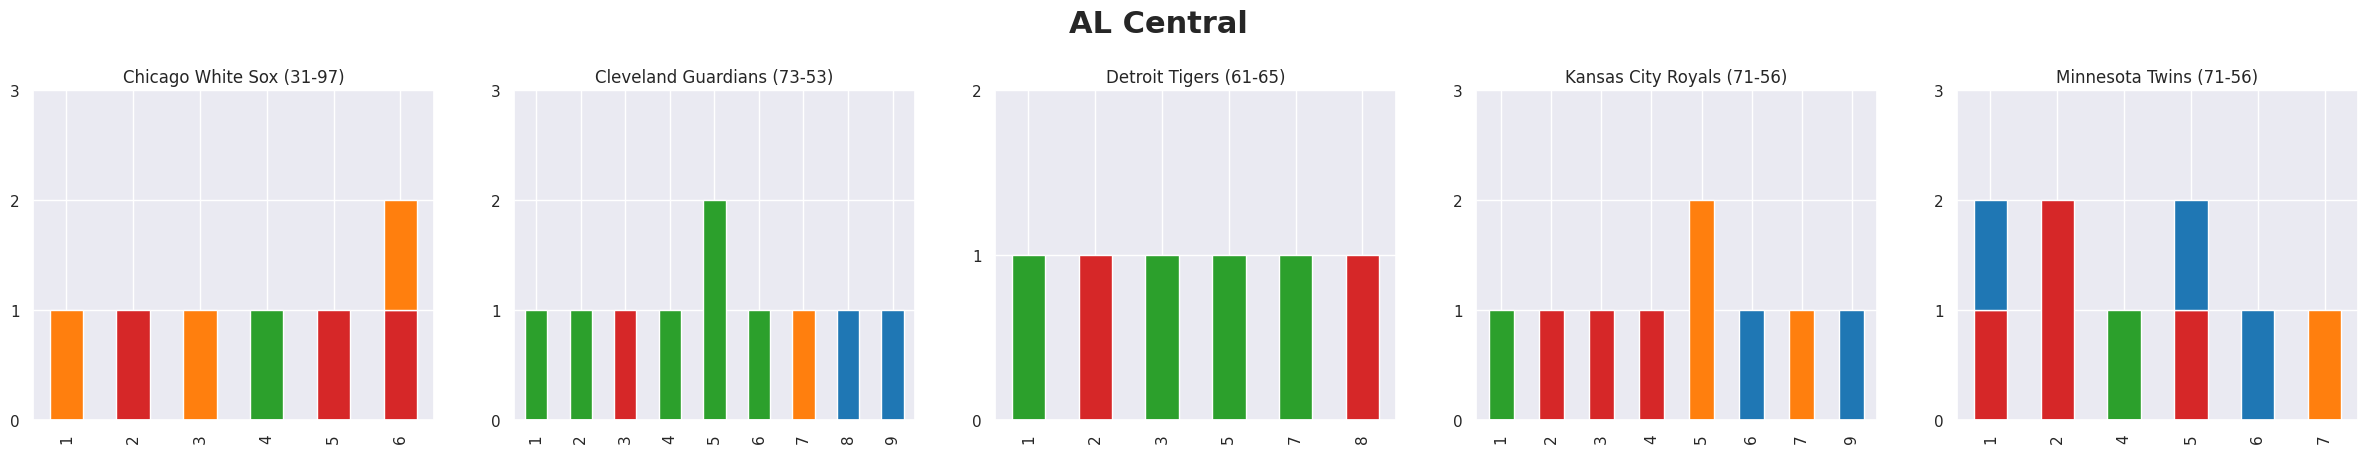

In [667]:
# Define the color map 
color_map = {'Struggling': 'tab:blue', 'Elite': 'tab:red', 'Power Oriented': 'tab:orange', '.BA Oriented': 'tab:green'}

# Get the colors for the bars
colors = [color_map[col] for col in Teams_Grouped.columns]


# Create a subplot matrix with plots for the 5 divisional teams

# Create the frame for subplots
fig, ax = plt.subplots(figsize = (15,15))

# Add Axes and Individual Grids - Subplot Grids
ax1 = plt.subplot2grid(shape=(6,5), loc=(0,0))
ax2 = plt.subplot2grid(shape=(6,5), loc=(0,1))
ax3 = plt.subplot2grid(shape=(6,5), loc=(0,2))
ax4 = plt.subplot2grid(shape=(6,5), loc=(0,3))
ax5 = plt.subplot2grid(shape=(6,5), loc=(0,4))


# Chicago White Sox
CHW = grouped[grouped['Team'] == "CHW"]
CHWplot = CHW.groupby(['Role', 'hit_class']).size().unstack()
# Create the stacked bar chart
CHWplot.plot(kind='bar', stacked=True, figsize=(30,30), color=colors, ax=ax1, title = 'Chicago White Sox (31-97)', xlabel = '')
ax1.legend().remove()
# Set y-axis intervals to 1.0
y_min, y_max = ax1.get_ylim()
ax1.set_yticks(np.arange(y_min, y_max + 1, 1))  # Adjust interval to 1.0

# Cleveland Guardians
CLE = grouped[grouped['Team'] == "CLE"]
CLEplot = CLE.groupby(['Role', 'hit_class']).size().unstack()
# Create the stacked bar chart
CLEplot.plot(kind='bar', stacked=True, figsize=(30,30), color=colors, ax=ax2, title = 'Cleveland Guardians (73-53)', xlabel = '')
ax2.legend().remove()
# Set y-axis intervals to 1.0
y_min, y_max = ax2.get_ylim()
ax2.set_yticks(np.arange(y_min, y_max + 1, 1))  # Adjust interval to 1.0

# Detroit Tigers
DET = grouped[grouped['Team'] == "DET"]
DETplot = DET.groupby(['Role', 'hit_class']).size().unstack()
# Create the stacked bar chart
DETplot.plot(kind='bar', stacked=True, figsize=(30,30), color=colors, ax=ax3, title = 'Detroit Tigers (61-65)', xlabel = '')
ax3.legend().remove()
# Set y-axis intervals to 1.0
y_min, y_max = ax3.get_ylim()
ax3.set_yticks(np.arange(y_min, y_max + 1, 1))  # Adjust interval to 1.0

# Kansas City Royals
KCR = grouped[grouped['Team'] == "KCR"]
KCRplot = KCR.groupby(['Role', 'hit_class']).size().unstack()
# Create the stacked bar chart
KCRplot.plot(kind='bar', stacked=True, figsize=(30,30), color=colors, ax=ax4, title = 'Kansas City Royals (71-56)', xlabel = '')
ax4.legend().remove()
# Set y-axis intervals to 1.0
y_min, y_max = ax4.get_ylim()
ax4.set_yticks(np.arange(y_min, y_max + 1, 1))  # Adjust interval to 1.0

# Minnesota Twins
MIN = grouped[grouped['Team'] == "MIN"]
MINplot = MIN.groupby(['Role', 'hit_class']).size().unstack()
# Create the stacked bar chart
MINplot.plot(kind='bar', stacked=True, figsize=(30,30), color=colors, ax=ax5, title = 'Minnesota Twins (71-56)', xlabel = '')
ax5.legend().remove()
# Set y-axis intervals to 1.0
y_min, y_max = ax5.get_ylim()
ax5.set_yticks(np.arange(y_min, y_max + 1, 1))  # Adjust interval to 1.0

# Built a title for the entire subplot grid
fig.suptitle('AL Central', fontsize=22, weight='bold', y = 0.907)



plt.show()

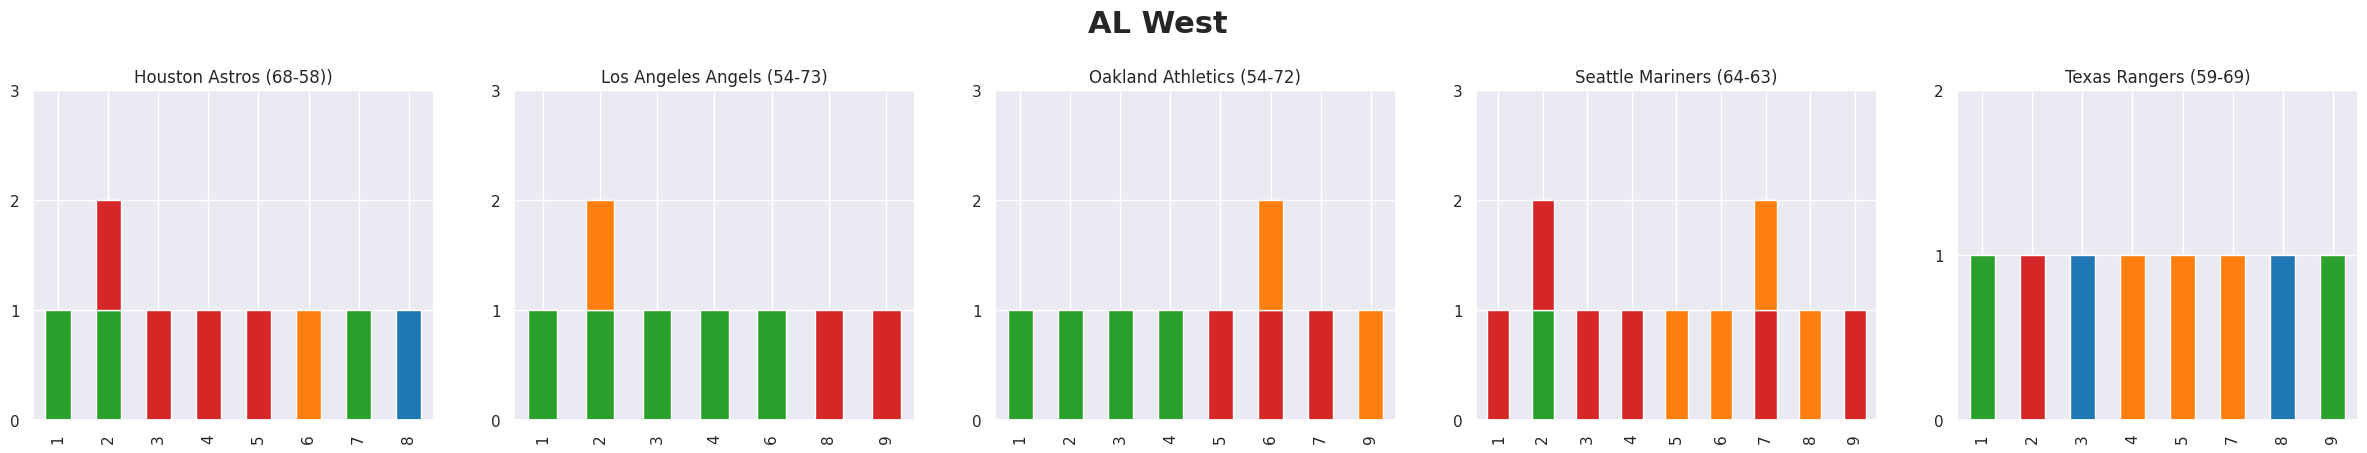

In [668]:
# Define the color map 
color_map = {'Struggling': 'tab:blue', 'Elite': 'tab:red', 'Power Oriented': 'tab:orange', '.BA Oriented': 'tab:green'}

# Get the colors for the bars
colors = [color_map[col] for col in Teams_Grouped.columns]


# Create a subplot matrix with plots for the 5 divisional teams

# Create the frame for subplots
fig, ax = plt.subplots(figsize = (15,15))

# Add Axes and Individual Grids - Subplot Grids
ax1 = plt.subplot2grid(shape=(6,5), loc=(0,0))
ax2 = plt.subplot2grid(shape=(6,5), loc=(0,1))
ax3 = plt.subplot2grid(shape=(6,5), loc=(0,2))
ax4 = plt.subplot2grid(shape=(6,5), loc=(0,3))
ax5 = plt.subplot2grid(shape=(6,5), loc=(0,4))


# Houston Astros
HOU = grouped[grouped['Team'] == "HOU"]
HOUplot = HOU.groupby(['Role', 'hit_class']).size().unstack()
# Create the stacked bar chart
HOUplot.plot(kind='bar', stacked=True, figsize=(30,30), color=colors, ax=ax1, title = 'Houston Astros (68-58))', xlabel = '')
ax1.legend().remove()
# Set y-axis intervals to 1.0
y_min, y_max = ax1.get_ylim()
ax1.set_yticks(np.arange(y_min, y_max + 1, 1))  # Adjust interval to 1.0

# Los Angeles Angels
LAA = grouped[grouped['Team'] == "LAA"]
LAAplot = LAA.groupby(['Role', 'hit_class']).size().unstack()
# Create the stacked bar chart
LAAplot.plot(kind='bar', stacked=True, figsize=(30,30), color=colors, ax=ax2, title = 'Los Angeles Angels (54-73)', xlabel = '')
ax2.legend().remove()
# Set y-axis intervals to 1.0
y_min, y_max = ax2.get_ylim()
ax2.set_yticks(np.arange(y_min, y_max + 1, 1))  # Adjust interval to 1.0

# Oakland Athletics
OAK = grouped[grouped['Team'] == "OAK"]
OAKplot = OAK.groupby(['Role', 'hit_class']).size().unstack()
# Create the stacked bar chart
OAKplot.plot(kind='bar', stacked=True, figsize=(30,30), color=colors, ax=ax3, title = 'Oakland Athletics (54-72)', xlabel = '')
ax3.legend().remove()
# Set y-axis intervals to 1.0
y_min, y_max = ax3.get_ylim()
ax3.set_yticks(np.arange(y_min, y_max + 1, 1))  # Adjust interval to 1.0

# Seattle Mariners
SEA = grouped[grouped['Team'] == "SEA"]
SEAplot = SEA.groupby(['Role', 'hit_class']).size().unstack()
# Create the stacked bar chart
SEAplot.plot(kind='bar', stacked=True, figsize=(30,30), color=colors, ax=ax4, title = 'Seattle Mariners (64-63)', xlabel = '')
ax4.legend().remove()
# Set y-axis intervals to 1.0
y_min, y_max = ax4.get_ylim()
ax4.set_yticks(np.arange(y_min, y_max + 1, 1))  # Adjust interval to 1.0

# Texas Rangers
TEX = grouped[grouped['Team'] == "TEX"]
TEXplot = TEX.groupby(['Role', 'hit_class']).size().unstack()
# Create the stacked bar chart
TEXplot.plot(kind='bar', stacked=True, figsize=(30,30), color=colors, ax=ax5, title = 'Texas Rangers (59-69)', xlabel = '')
ax5.legend().remove()
# Set y-axis intervals to 1.0
y_min, y_max = ax5.get_ylim()
ax5.set_yticks(np.arange(y_min, y_max + 1, 1))  # Adjust interval to 1.0

# Built a title for the entire subplot grid
fig.suptitle('AL West', fontsize=22, weight='bold', y = 0.907)


plt.show()

**ANALYSIS & IMPLICATIONS:**

# Player Development-based Insights: Data Exploration & Modelling

Leveraging my comprehensive understanding of bat speed & its implications on the MLB, I want to apply predictive analytics to answer the following:

1. Who are some players who could **significantly benefit from a 0.1 - 2 mph increase** to their bat speed? - Candidates for regression
2. Who are some players which could suffer from **a 0.1 - 1 mph loss in** their bat speed? - Candidates for Regression

## Candidates For Development

For purposes of this analysis, I've identified two player groups whom are 'ideal' candidates from a player-development perspective. I'll focus on hitters who could add a **0.1 - 2 mph** to their bat speed, being able to shift their current hitting classification to a more ideal one. I'll also focus on players **within 0.005 of the xBA** average, performing very close to the current average.

I recognize that bat speed isn't the only determinant in player development/improvement, so the results should be only be the start of this identification process. I just find it as a fun exercise to identify these potential hitters, potentially seeing them succeed due to subsequent increases in bat speed.

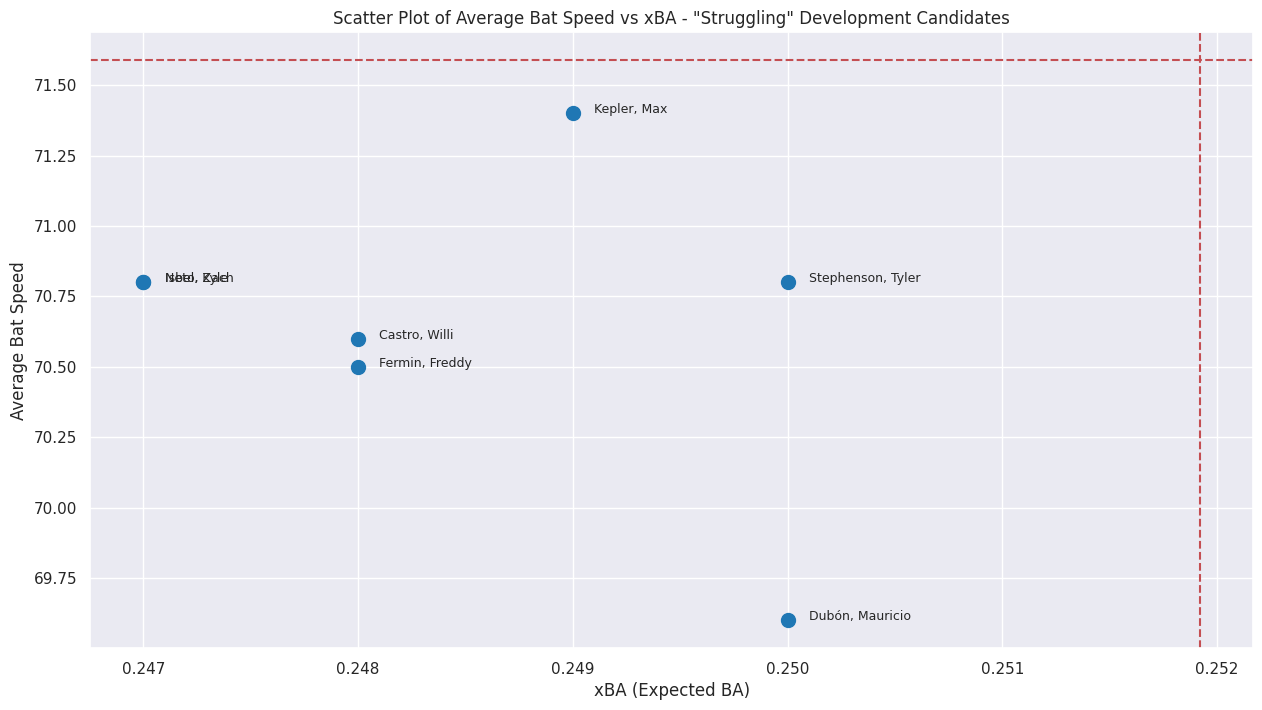

In [669]:
# Identify players who are within 2 mph of the bat speed average
Struggling = grouped[grouped['hit_class'] == "Struggling"]
Strug_filter = Struggling[Struggling['avg_swing_speed'] >= 71.5883018867924 - 2]
Strug_Dev = Strug_filter[Strug_filter['xba'] >=  0.25192075471698117 - 0.005]


# Apply color for struggling
colors = ['tab:blue']

# Create the scatter plot
plt.figure(figsize=(15, 8))
plt.scatter(Strug_Dev['xba'], Strug_Dev['avg_swing_speed'], color=colors, s=100)
plt.xlabel('xBA (Expected BA)')
plt.ylabel('Average Bat Speed')
plt.title('Scatter Plot of Average Bat Speed vs xBA - "Struggling" Development Candidates')
plt.grid(True)

# Plot averages
plt.axhline(y=71.5883018867924, color='r', linestyle='--', label = '_nolegend_')
plt.axvline(x=0.25192075471698117, color='r', linestyle='--', label = '_nolegend_')

# Plot the name
for i, row in Strug_Dev.iterrows():
    plt.text(row['xba'] + 0.0001, row['avg_swing_speed'], 
             row['last_name, first_name'], fontsize=9, ha='left')


In [670]:
# View Players Who Are Candidates For Development
Strug_Dev

,"last_name, first_name",player_id,year,pa,home_run,k_percent,bb_percent,xba,xslg,xwoba,...,pull_percent,straightaway_percent,opposite_percent,groundballs_percent,flyballs_percent,linedrives_percent,hit_class,Team,Name,Role
46,"Kepler, Max",596146,2024,362,8,20.4,5.8,0.249,0.395,0.308,...,39.8,32.6,27.6,34.1,33.0,25.3,Struggling,MIN,Max Kepler,6
92,"Dubón, Mauricio",643289,2024,311,4,12.9,3.9,0.250,0.338,0.275,...,29.2,38.5,32.3,42.0,27.2,24.1,Struggling,HOU,Mauricio Dubón,8
104,"Castro, Willi",650489,2024,492,10,24.4,7.9,0.248,0.391,0.320,...,40.9,35.2,23.9,40.6,26.4,27.4,Struggling,MIN,Willi Castro,1
135,"Stephenson, Tyler",663886,2024,372,16,18.8,8.9,0.250,0.429,0.331,...,39.0,35.6,25.4,45.8,29.9,21.2,Struggling,CIN,Tyler Stephenson,3
143,"Isbel, Kyle",664728,2024,319,7,18.5,6.3,0.247,0.361,0.292,...,40.9,34.2,24.9,52.7,20.3,21.1,Struggling,KCR,Kyle Isbel,9
158,"Fermin, Freddy",666023,2024,265,6,17.0,6.4,0.248,0.355,0.289,...,46.3,37.8,15.9,48.8,24.4,19.9,Struggling,KCR,Freddy Fermin,6
253,"Neto, Zach",687263,2024,449,17,22.5,6.2,0.247,0.444,0.329,...,43.7,35.6,20.7,45.0,28.2,19.1,Struggling,LAA,Zach Neto,2


Applying my initial criteria, I received **7 potential candidates** for development

To narrow down my list of candidates, I'll need to **construct a predictive model which estimates a player's performance depending on their bat speed**. Using this predictive model, I will predict the 10 candidates metrics assuming they increased their bat speeds to some degree. This will be tested in intervals, allowing me to see by **how much their metrics increase as I add 0.1 mph to their average bat speeds**. 

Keep in mind, this data only spans from April 3rd to August 16th, so it is somewhat **limited**. Regardless, I'm interested to see what results could be yielded.


Let's begin by re-examining the correlation between average bat speed and offensive performance metrics:

## Candidates for Regression

To identify candidates for regression, I'll focus on players who are not in the "Struggling" classification, but very close to the average bat speed and xBA thresholds (**within 0.005 xBA** of the average, **0.1 - 1 mph** of the average bat speed). 

Upon identifying these candidates, I'll apply the predictive model I identified earlier, observing how each players' performance would decline as their bat speed decreases. 

Upon identifying these candidates, I will investigate their historical performance and other relevant factors to fully assess whether they may regress.

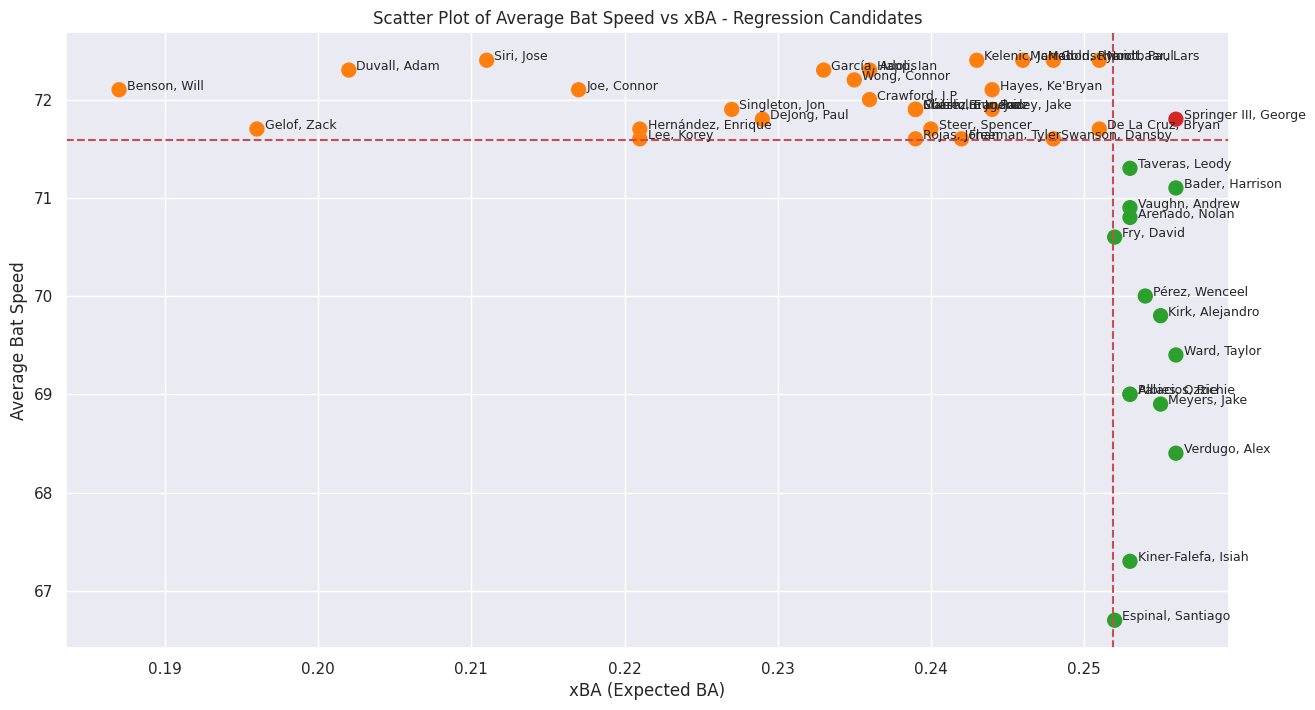

In [671]:
# Identify players who are within 2 mph of the bat speed average
NotStruggling = grouped[grouped['hit_class'] != "Struggling"]
Filter = NotStruggling[NotStruggling['avg_swing_speed'] <= 71.5883018867924 + 1]
Regr = Filter[Filter['xba'] <=  0.25192075471698117 + 0.005]


# Define a color map for the 'hit_class' categories
color_map = {'Elite':'tab:red', 'Power Oriented':'tab:orange', '.BA Oriented':'tab:green'}
# Map the 'hit_class' values to colors
colors = Regr['hit_class'].map(color_map)

# Create the scatter plot
plt.figure(figsize=(15, 8))
plt.scatter(Regr['xba'], Regr['avg_swing_speed'], color=colors, s=100)
plt.xlabel('xBA (Expected BA)')
plt.ylabel('Average Bat Speed')
plt.title('Scatter Plot of Average Bat Speed vs xBA - Regression Candidates')
plt.grid(True)

# Plot averages
plt.axhline(y=71.5883018867924, color='r', linestyle='--', label = '_nolegend_')
plt.axvline(x=0.25192075471698117, color='r', linestyle='--', label = '_nolegend_')

# Plot the name
for i, row in Regr.iterrows():
    plt.text(row['xba'] + 0.0005, row['avg_swing_speed'], 
             row['last_name, first_name'], fontsize=9, ha='left')


In [672]:
Regr

,"last_name, first_name",player_id,year,pa,home_run,k_percent,bb_percent,xba,xslg,xwoba,...,pull_percent,straightaway_percent,opposite_percent,groundballs_percent,flyballs_percent,linedrives_percent,hit_class,Team,Name,Role
6,"Goldschmidt, Paul",502671,2024,506,19,27.3,7.5,0.248,0.447,0.325,...,38.8,35.7,25.5,42.8,27.7,23.1,Power Oriented,STL,Paul Goldschmidt,7
16,"Springer III, George",543807,2024,469,14,19.2,10.2,0.256,0.418,0.330,...,37.2,40.5,22.3,50.0,21.6,22.6,Elite,TOR,George Springer,1
20,"Suárez, Eugenio",553993,2024,475,18,27.6,8.4,0.239,0.421,0.321,...,49.2,29.2,21.7,32.2,31.2,27.5,Power Oriented,ARI,Eugenio Suárez,7
22,"Arenado, Nolan",571448,2024,480,12,13.8,7.1,0.253,0.359,0.298,...,45.3,36.0,18.7,38.9,24.5,26.9,.BA Oriented,STL,Nolan Arenado,5
24,"Hernández, Enrique",571771,2024,311,7,20.6,8.0,0.221,0.343,0.278,...,35.1,39.6,25.2,36.0,29.7,25.2,Power Oriented,LAD,Enrique Hernández,8
25,"Singleton, Jon",572138,2024,324,10,27.5,11.1,0.227,0.362,0.300,...,40.7,35.7,23.6,42.2,27.1,26.1,Power Oriented,HOU,Jon Singleton,6
41,"Duvall, Adam",594807,2024,318,10,30.8,6.3,0.202,0.396,0.285,...,49.0,32.7,18.4,30.1,35.2,18.9,Power Oriented,ATL,Adam Duvall,6
62,"Swanson, Dansby",621020,2024,434,9,25.1,8.8,0.248,0.419,0.321,...,44.9,35.1,20.0,49.5,21.8,23.5,Power Oriented,CHC,Dansby Swanson,7
67,"Ward, Taylor",621493,2024,489,16,25.2,9.6,0.256,0.469,0.351,...,31.7,35.9,32.4,32.7,35.9,28.6,.BA Oriented,LAA,Taylor Ward,1
79,"Crawford, J.P.",641487,2024,335,9,22.7,11.3,0.236,0.388,0.316,...,34.2,41.6,24.2,45.2,26.0,21.9,Power Oriented,SEA,J.P. Crawford,1


# Summary & Conclusion